In [121]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [122]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.ticker as ticker
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

import openpyxl
#import osgeo
#from osgeo import gdal
#from openpyxl.workbook import Workbook

In [123]:
### PREP DATA ###

## MANUAL INPUT ## -- locate file
sensor = 'PRISMA' #'PRISMA', 'WV3', 'Landsat8', 'terraspec'
target_file = 'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' + sensor + '_spots.xlsx'
#sensor_meta = pd.read_csv('C:/Users/htccr/Documents/Aconquija/python_scripts/keep/'+ sensor + '_meta.csv', header = 0, index_col = None)
sensor_meta = pd.read_csv('C:/Users/htccr/Documents/Aconquija/python_scripts/keep/PRISMA_meta.csv', header = 0, index_col = None)

data = pd.read_excel(target_file, sheet_name = 'band_mean', header = None, index_col = None) # choose sheet: 'band_mean', 'continuum', 'continuum_removed'
data_std = pd.read_excel(target_file, sheet_name = 'band_std', header = None, index_col = None)
data_vars = pd.read_excel(target_file, sheet_name = 'variables', header = 0, index_col = None)
spots_meta = pd.read_excel('C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/spots_meta.xlsx',sheet_name = 'Sheet1', header = 0, index_col = None)

# decompact data_vars
age = np.array(data_vars['age'])
age_sd = np.array(data_vars['age_sd'])
age_n = np.array(data_vars['age_n'])
fan = np.array(data_vars['fan'])
unit = np.array(data_vars['unit'])
unique = np.array(data_vars['unique'])
pix_count = np.array(data_vars['pix_count'])

# decompact sensor metadata (e.g. nm, band names) and create dictionaries
band_names = sensor_meta.Band
nm_names = sensor_meta.nm.values
nm_names = np.round(nm_names,1)
band_dict_nm = pd.Series(sensor_meta.Name.values,index=nm_names).to_dict()
band_dict_idx  = pd.Series(sensor_meta.Name.values,index=sensor_meta.index.values).to_dict() # create dictionary of band names to wavelength
nm_dict = pd.Series(sensor_meta.nm.values,index=sensor_meta.Band).to_dict() # create dictionary of band names to wavelength

if 'bad_age_idx' in locals():
    del bad_age_idx
if 'bad_band_idx' in locals():
    del bad_band_idx

## MANUAL INPUT ## -- set bands and/or ages to drop
bad_band_idx = np.r_[97:110,141:169,226:230] # choose bands to drop by index #terraspec, np.r_[2147:2150]
bad_age_idx = np.where((pix_count == 0) )#| (pix_count <10))#(age == 3.37) | (age == 16.48) | (age == 78.5) | (age == 314.48)) #(pix_count == 0) | (pix_count <10)) # | (unit == 'Q2.5a') | (unit == 'Q2.5b')) #  choose age to drop (two decimels)
if 'bad_age_idx' in locals():
    data = data.drop(np.r_[bad_age_idx], axis=0)
    data_std = data_std.drop(np.r_[bad_age_idx], axis=0)
    age = np.delete(age, bad_age_idx)
    age_sd = np.delete(age_sd, bad_age_idx)
    age_n = np.delete(age_n, bad_age_idx)
    fan = np.delete(fan, bad_age_idx)
    unit = np.delete(unit, bad_age_idx)
    unique = np.delete(unique, bad_age_idx)
    pix_count = np.delete(pix_count, bad_age_idx)
    spots_meta = spots_meta.drop(np.r_[bad_age_idx], axis=0)
    
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('some ages dropped')
else:
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('No ages dropped')
    
# drop chosen values from dataset(s)
if 'bad_band_idx' in locals():
    #data = data.drop(np.r_[bad_band_idx], axis=1)
    #nm_names = np.delete(nm_names, bad_band_idx)
    data.iloc[:,bad_band_idx] = np.nan # if bad bands chosen, set band bands as 0 for PCA` #!!change to 0 if NOT normalizign first!!!
    #data_std.iloc[:,bad_band_idx] = np.nan #!!change to 0 if NOT normalizign first!!!
    nm_names = np.delete(nm_names, np.r_[226:230])
    
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    #data_std_plot = data_std.copy()
    data_plot.iloc[:,bad_band_idx] = np.nan
   # data_std_plot.iloc[:,bad_band_idx] = np.nan
    print('some bands dropped')
else:
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    #data_std_plot = data_std.copy()
    print('No bands dropped')

print(np.shape(data))

some ages dropped
some bands dropped
(22, 230)


#### Normalize data (optional), PCA function will appl normilization??

In [1152]:
# replace indexs with np.nan as 0 so PCA can work while still holding the correct nm placements
data.iloc[:,bad_band_idx] = 0
data_std.iloc[:,bad_band_idx] = 0

In [753]:
# Normalize, both within an observation (so all bands are evenly weighted), between observations

# carry std through-- create relative matrix of std to refelctance value (i.e. decimel percentage), normlaize data, re-calc std using matrix
data_std = data_std/data.mean()
data_std[np.isnan(data_std)] = 0

# normalize each observation to have the same mean & std
#data = (data - data.mean())/data.std()
data = (data.T - data.T.mean())/data.T.std()
data = data.T
data[np.isnan(data)] = 0

In [ ]:
# 1st derivative
data = np.diff(data)/np.diff(nm_names)
data = pd.DataFrame(data)

nm_names = nm_names[1:]
data[np.isnan(data)] = 0

In [482]:
# normalize to a particular band (i.e. to Band 1 as zero), scale all observation 0 - 1 
data = (data.T -  data.T.iloc[10]) # choose band as zero point
max_all = data.max().max()
min_all = data.min().min()
data = (data - min_all)/(max_all - min_all) 
data = data.T
data[np.isnan(data)] = 0

In [1161]:
# normlaize by BCET, on the final dataset (???)
# followed by normalization to a particular band
count = len(data.T)
BCET = pd.DataFrame()

for band_n in range(count):

    # Read band
    dat = data.iloc[:,band_n].astype(np.float64)

    # Shift the left minimum value to the current minimum, so the smallest value is now shifted to zero
    dat_masked_new = dat-np.min(dat)
    
    # Normalize between 0 and 1
    dat_masked_new *= 1/dat_masked_new.max()
    
    L = 0 # desired output minimum
    H = 1  # desired output maximum, set to max bit-depth range
    E = H/2 # desired output mean

    ### BCET ###

    s = np.nanmean(np.power(dat_masked_new,2)) # mean squared
    e = np.nanmean(dat_masked_new)
    l = np.nanmin(dat_masked_new)
    h = np.nanmax(dat_masked_new)

    # Find b
    b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))
    b_den = 2*((h*(E-L))-(e*(H-L))+(l*(H-E)))

    b = b_nom/b_den

    # Find a
    a1 = H-L
    a2 = h-l
    a3 = h+l-(2*b)

    a = a1/(a2*a3)

    # Find c
    c = L-(a*(l-b)**2)
    
        # BCET malfunction test as in Lui & Mason (2016) Section 2.6.1. Where l<b<h BCET malfunctions. 
    if (l < b) & (b < h):
        print('\033[91m'+ 'BCET Fail' + '\033[0;0m' + ' (Band {})'.format(band_n + 1)) # print in red
        print("l, b, h --> ", l,", ", b,", ",h)
    else:
        pass #print('\033[92m' + 'BCET Pass' + '\033[0;0m' + ' (Band {})'.format(band_n + 1)) # print in green

    #print("l, b, h --> ", l,", ", b,", ",h)
    #print('------------------------------')
    #print(bcet_raster.shape)

    # Process raster
    bcet_raster = a*((dat_masked_new - b)**2) + c
    #BCET[band_n] = bcet_raster # replcaced w/ below
    hold = pd.Series(bcet_raster, name = band_n)
    to_concat = [BCET, hold]
    BCET = pd.concat(to_concat, axis = 1)

print('dynamic range ', L, 'to', H) # prints the desired dynamic range of the output image
print('target mean ', E) # prints the desired mean of the output image, 'E'
print('actual mean', np.mean(BCET.mean()))
print("processing complete.")
 
data = BCET
data[np.isnan(data)] = 0

C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:23: RuntimeWarning: Mean of empty slice
  s = np.nanmean(np.power(dat_masked_new,2)) # mean squared
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:24: RuntimeWarning: Mean of empty slice
  e = np.nanmean(dat_masked_new)
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:25: RuntimeWarning: All-NaN axis encountered
  l = np.nanmin(dat_masked_new)
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:26: RuntimeWarning: All-NaN axis encountered
  h = np.nanmax(dat_masked_new)
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:23: RuntimeWarning: Mean of empty slice
  s = np.nanmean(np.power(dat_masked_new,2)) # mean squared
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:24: RuntimeWarning: Mean of empty slice
  e = np.nanmean(dat_masked_new)
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:25: RuntimeWarning: All-NaN axis encountered
  l = n

dynamic range  0 to 1
target mean  0.5
actual mean 0.5
processing complete.


C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:23: RuntimeWarning: Mean of empty slice
  s = np.nanmean(np.power(dat_masked_new,2)) # mean squared
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:24: RuntimeWarning: Mean of empty slice
  e = np.nanmean(dat_masked_new)
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:25: RuntimeWarning: All-NaN axis encountered
  l = np.nanmin(dat_masked_new)
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:26: RuntimeWarning: All-NaN axis encountered
  h = np.nanmax(dat_masked_new)
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:23: RuntimeWarning: Mean of empty slice
  s = np.nanmean(np.power(dat_masked_new,2)) # mean squared
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:24: RuntimeWarning: Mean of empty slice
  e = np.nanmean(dat_masked_new)
C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\2848004523.py:25: RuntimeWarning: All-NaN axis encountered
  l = n

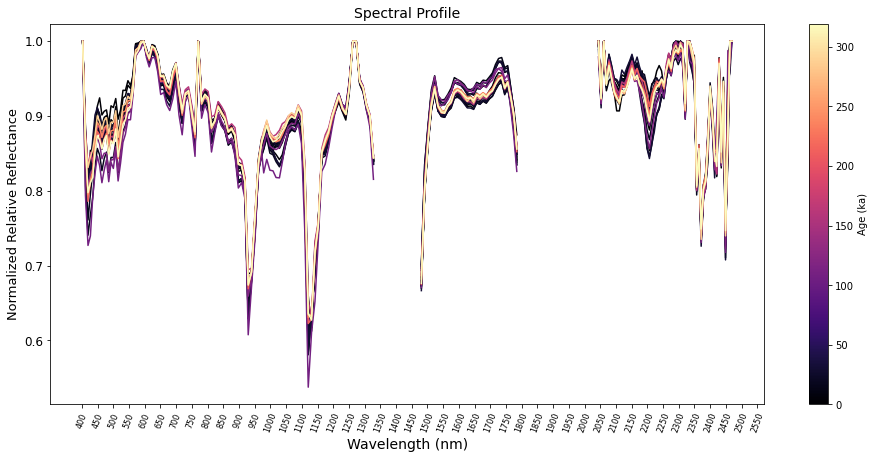

In [7]:
#plot
norm = plt.Normalize(vmin=min(age), vmax=max(age))

target_x = nm_names
target_y = data
target_names = age
yerr = data_std

N = len(target_y) # number of objects to plot i.e. color cycle count

fig, ax = plt.subplots(figsize = (16,7))
#for i in range(N):
    #ax.plot(target_x, target_y.iloc[i], label = target_names[i]) # for i in range of objects, plot x,y
for i in range(N): 
    ax.plot(target_x, target_y.iloc[i],label = target_names[i], color=plt.cm.magma(norm(age[i])))
    #ax.errorbar(target_x, target_y.iloc[i], yerr=yerr.iloc[i], color=plt.cm.viridis(norm(age[i])), alpha = 0.5, fmt='-o')
#axes
#plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.xticks(np.arange(400, 2600, 50), fontsize = 10, rotation=70, size = 8)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xlabel('Wavelength (nm)', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel('Normalized Relative Reflectance', fontsize = 13)
plt.title("Spectral Profile", size = 14)
plt.title
plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

# legend location (if using discrete line key)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0 + box.height * 0.1,
                # box.width, box.height * .9])

#ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          #fancybox=True, shadow=True, ncol=1, title = 'Age (ky)') # Put a legend below current axis

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [30]:
x = 1
print(nm_names[x])
print(data[x])


2214.3
0     0.900876
1     0.942993
2     0.924841
3     0.866170
4     0.915454
5     0.914109
6     0.918098
7     0.861162
8     0.925125
10    0.941257
11    0.887452
12    0.927809
13    0.923947
14    0.863527
15    0.932548
17    0.903523
18    0.877831
19    0.920861
20    0.929352
21    0.919658
22    0.913710
24    0.912282
Name: 190, dtype: float64


(0.0, 35.0)

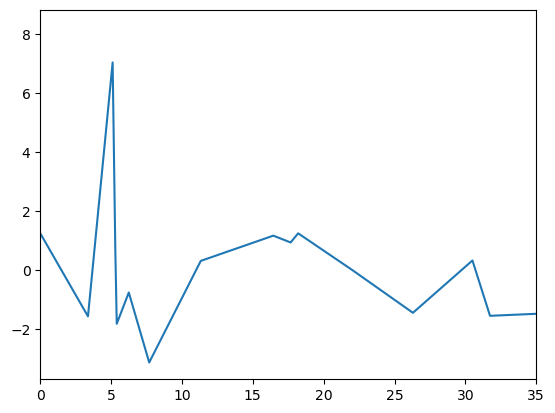

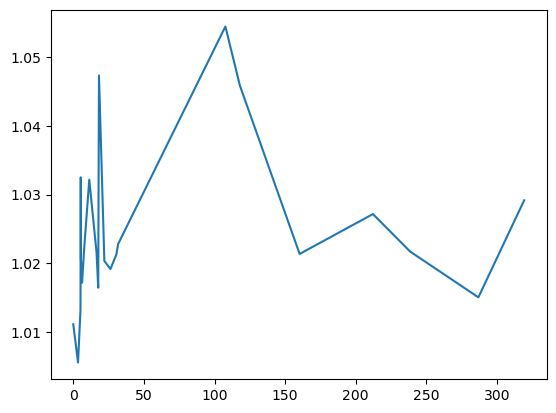

In [39]:
SWIR = data.T[115:128] + 1
VIS = data.T[6:15] + 1
numerator = np.nanmean(SWIR, axis = 0)
denomonator = np.nanmean(VIS, axis = 0)

data_ratio = data + 1
ratio = (numerator/denomonator)

plt.plot(age,ratio)

In [67]:
data[np.isnan(data)] = 0

n_modes = np.min(np.shape(data)) 
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

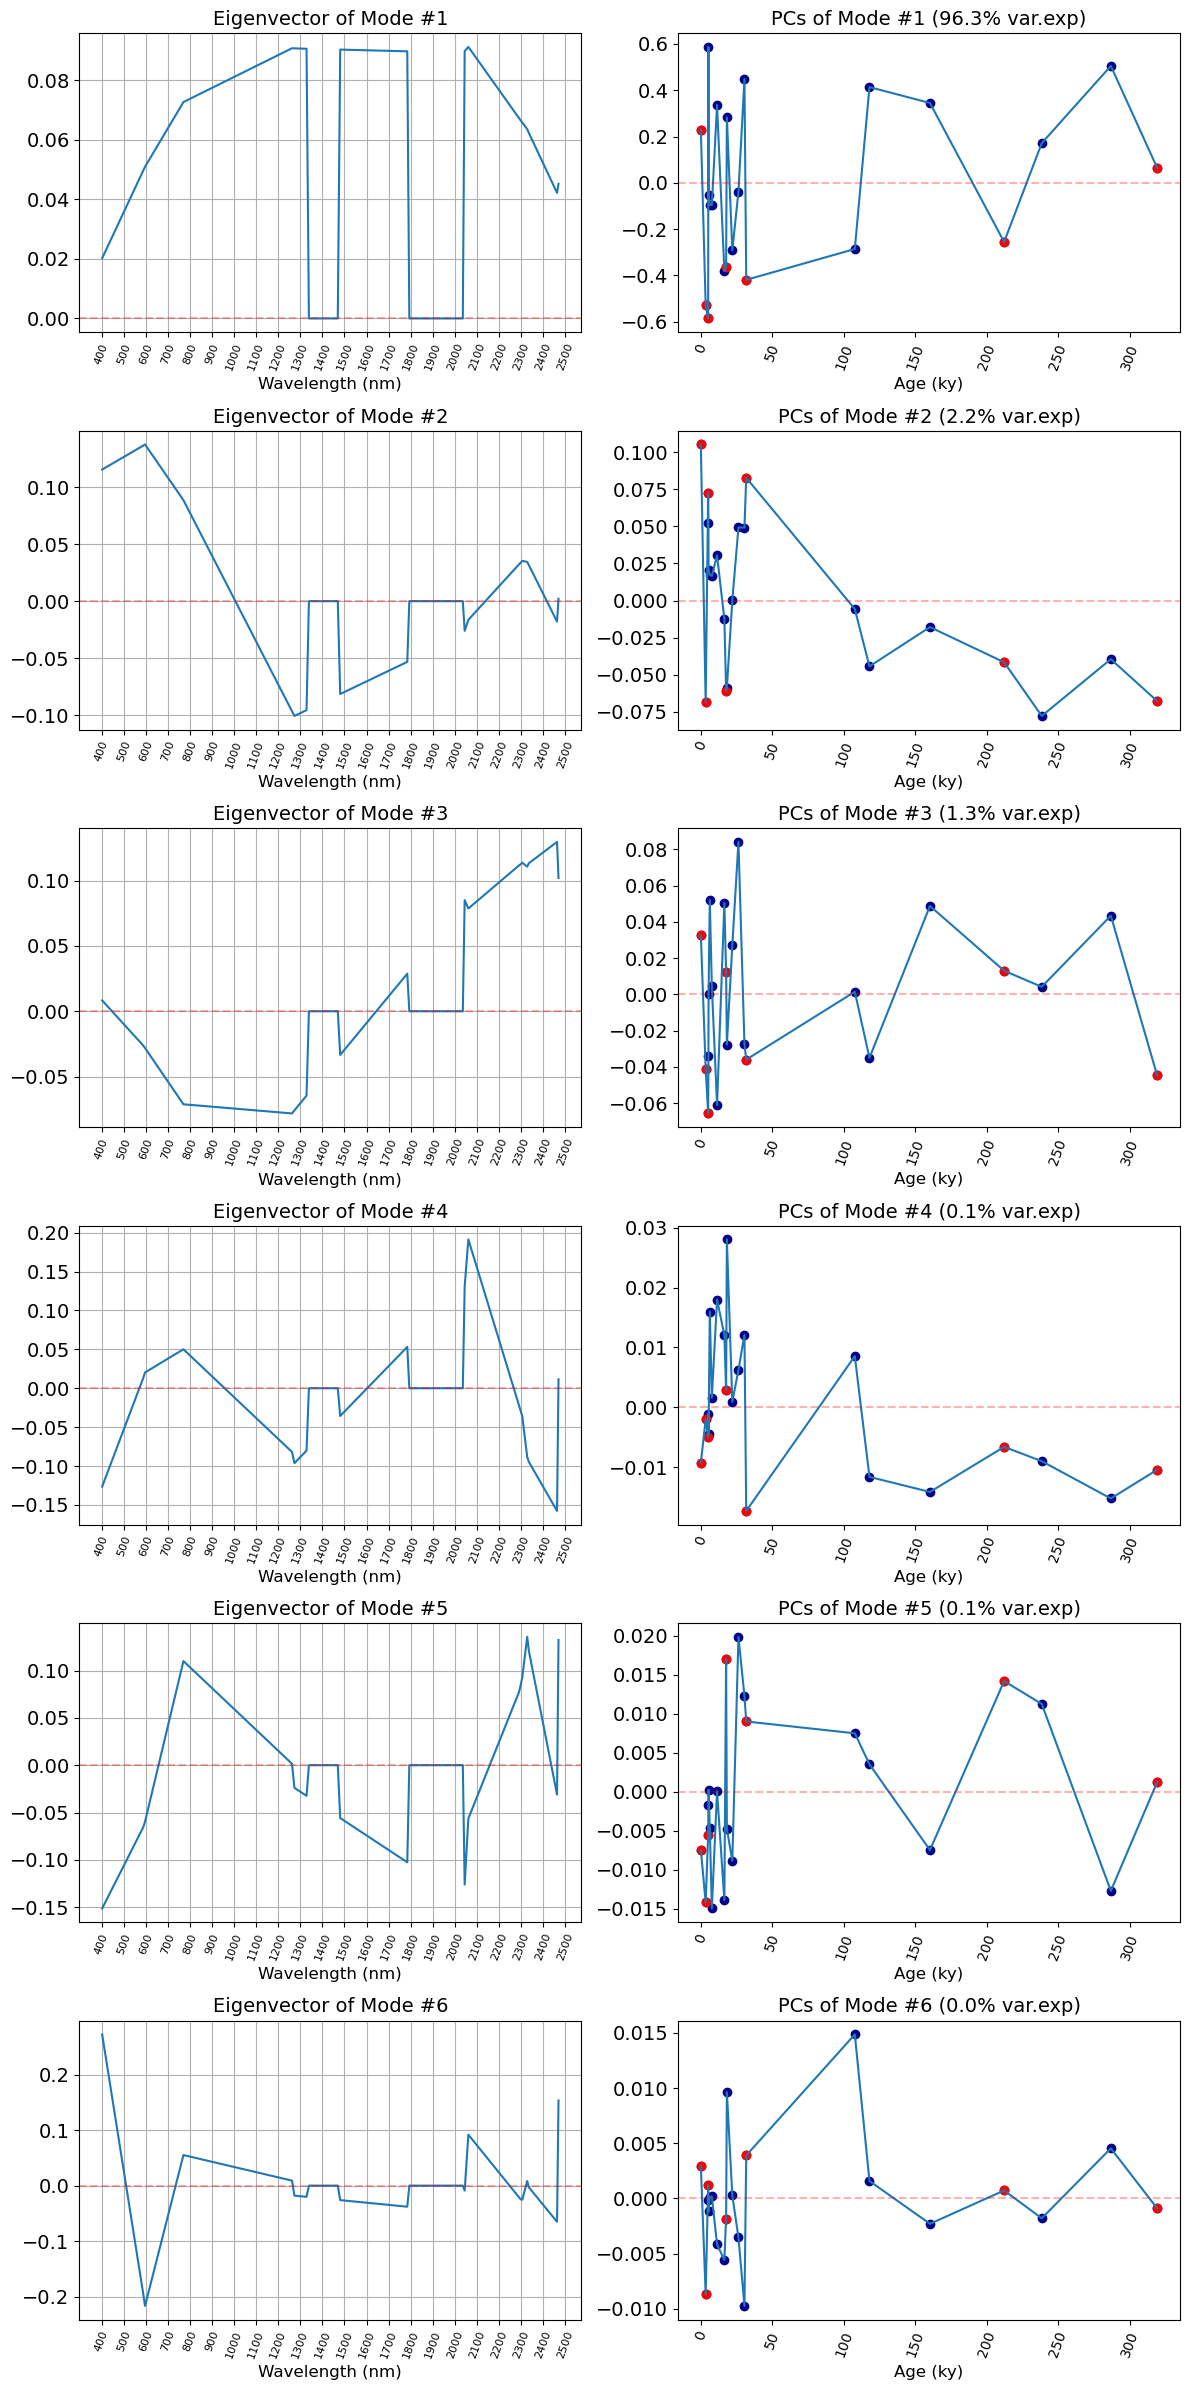

In [68]:
#plot the first n modes and PCs
n = 6

plt.figure(figsize=(12,4*n))
for kk in range(n):
    
    ax = plt.subplot(n,2,kk*2+1)
    plt.plot(nm_names,eigvecs[kk,:]) # extrat age as an array and do plt.plot(PCs[:,kk], age)
    plt.title('Eigenvector of Mode #' + str(kk+1), fontsize = 14)
    plt.xlabel('Wavelength (nm)', fontsize = 12)
    plt.xticks(fontsize = 10, rotation=70, size = 8)
    plt.xticks(np.arange(400, 2600, 100), fontsize = 10, rotation=70, size = 8)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    plt.grid()
    
    plt.subplot(n,2,(kk+1)*2)
    #plt.plot(age[1:],PCs[:,kk][1:], color = 'black')
    #plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
    #plt.plot(age_proxy, ice_proxy['dO18'], color = 'red', alpha =.8 ,label = 'Korner 2002 Global d18O (temp. proxy)')
    #plt.errorbar(age,PCs[:,kk], xerr=age_sd, fmt='o', c = 'darkblue', alpha = 0.8, zorder = 0)
    plt.plot(age,PCs[:,kk])#, c = 'darkblue', zorder = 1)
    plt.scatter(age,PCs[:,kk], c = 'darkblue', zorder = 1)
    #plt.colorbar(label = 'Age (ky)')
    plt.title('PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    plt.xlabel('Age (ky)', fontsize = 12)
    plt.xticks(fontsize = 14, rotation=70, size = 10)
    plt.yticks(fontsize = 14)  
    plt.tight_layout()
    plt.xlim()
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)

    highlight_age_idx = np.r_[np.where((age == 3.37) | (age == 16.48) | (age == 78.5) | (age == 314.48))]
    highlight_age_ages = age[highlight_age_idx]
    PCs_highlight_ages = PCs[:,kk][highlight_age_idx]
    plt.scatter(highlight_age_ages, PCs_highlight_ages, c = 'r')
    
    highlight_ra_idx = np.r_[np.where((unit == 'Q2.5a') | (unit == 'Q2.5b'))]
    highlight_ra_ages = age[highlight_ra_idx]
    PCs_highlight_ra = PCs[:,kk][highlight_ra_idx]
    #plt.scatter(highlight_ra_ages, PCs_highlight_ra, c = 'green')
    
    xrd_idx = np.r_[np.where((age == 0) | (age == 5.11) | (age == 17.67) | (age == 31.74) | (age == 212.15) | (age == 319.22))]
    plt.scatter(age[xrd_idx],PCs[:,kk][xrd_idx], c = 'red')
plt.show()

# yonger fan variation may be due to water on the fans, which effects the signal. Drier fans
# color by location
# invesitgate the PC1, for its age. 


In [511]:
# apply trained PCA to std data 
# MUST RUN PCA on training data first, and have in environmetnal varibales!
PCs_std_upper = pca.transform(data + data_std)
eigvecs_std_upper = pca.components_

PCs_std_lower= pca.transform(data - data_std)
eigvecs_std_lower = pca.components_

In [ ]:
PC_n = 0

diff_eig = (data.T[22] - data.T[0])

diff_eig = (diff_eig - diff_eig.min())/(diff_eig.max()-diff_eig.min())

PCA_eig = eigvecs[PC_n]
PCA_eig = (PCA_eig - PCA_eig.min())/(PCA_eig.max()-PCA_eig.min())

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(nm_names, diff_eig, c = 'red', label = 'eeigvec diff')
plt.plot(nm_names, PCA_eig, color = 'blue', label = 'PCA eigvec')
plt.legend()
plt.title('What is the eigvec?')

plt.subplot(122)
diff_PC = data*diff_eig 
diff_PC = np.sum(diff_PC, axis = 1)
diff_PC = (diff_PC - diff_PC.min())/(diff_PC.max() - diff_PC.min())

PCA_PC = PCs[:,PC_n]
PCA_PC = (PCA_PC - PCA_PC.min())/(PCA_PC.max()- PCA_PC.min())

plt.plot(age, diff_PC, c = 'r', label = 'PC_diff')
plt.scatter(age, PCA_PC, c = 'b', label = 'PCA PC')
plt.legend()
plt.xlim(0,350)

In [ ]:
plt.scatter(PCs[:,0],PCs[:,1], c = age)
plt.colorbar()

In [ ]:
plt.scatter(age,PCs[:,1], c = spots_meta['MeanElevat'])
plt.colorbar()

In [42]:
## TARGET PC ##
target_PC_n =0
target_PC = (PCs[:,target_PC_n])
#target_PC = np.array(ratio)

#carrry std through PCA
target_PC_std_upper = (PCs_std_upper[:,target_PC_n])
target_PC_std_lower = (PCs_std_lower[:,target_PC_n])
target_PC_std = np.abs(target_PC_std_upper - target_PC)
target_PC_std_matrix = np.abs(target_PC_std)/np.abs(target_PC.max()) # create std matrix


NameError: name 'PCs_std_upper' is not defined

C:\Users\htccr\AppData\Local\Temp\ipykernel_32844\3398968644.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(age, target_PC/age)
C:\Users\htccr\AppData\Local\Temp\ipykernel_32844\3398968644.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(age, target_PC/age)


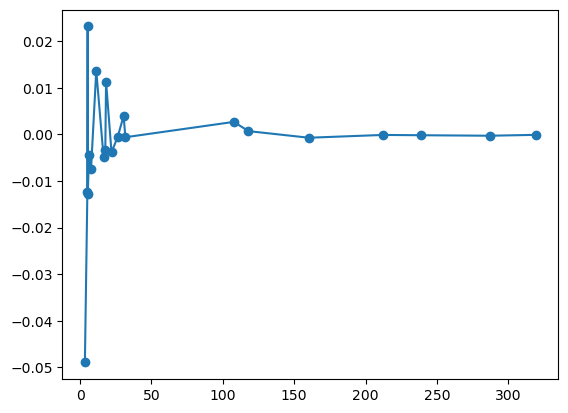

In [43]:
plt.scatter(age, target_PC/age)
plt.plot(age, target_PC/age)

In [505]:
np.log(.16)

-1.8325814637483102

(-15.961000000000002, 335.18100000000004)

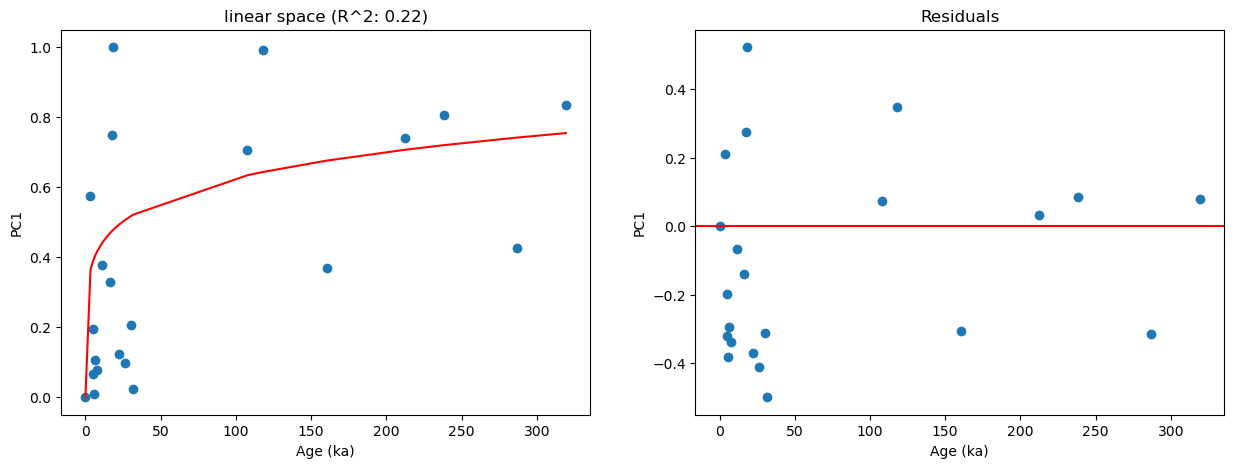

In [760]:
# define steady weathering rate of granites (White and Brandtly, 2001)
def weathering_rate(time):
    a = 3.31e-13 # white 2001
    b = 0.61 # white 2001
    a = 0.2691 # nui et al. 2019
    b = 0.1679 # nui et al. 2018
   # a = 0.59 # constant D'arcy
   # b = 0.16 # exponent D'arcy
    a = 0.3
    b = 0.16
    rate = a*(time**b)
    return(rate)

PC1_posative = (target_PC-min(target_PC))/(max(target_PC)-min(target_PC))
wr = weathering_rate(age)
#PC1_posative = target_PC  - target_PC.min()
residuals = PC1_posative - wr

# correlation coefficient (r^2)
r2 = r2_score(PC1_posative, wr)
r2 = round(r2,2)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.scatter(age, PC1_posative)
plt.plot(age, wr, color='red')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('linear space (R^2: {})'.format(r2))
#plt.xscale('log')
#plt.yscale('log')


plt.subplot(1,2,2)
plt.scatter(age, residuals)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('Residuals'.format(r2))

plt.xlim()

linear: y=[[0.12]]x+0.0
Power funtion: y = 1.0x^[[0.12]]


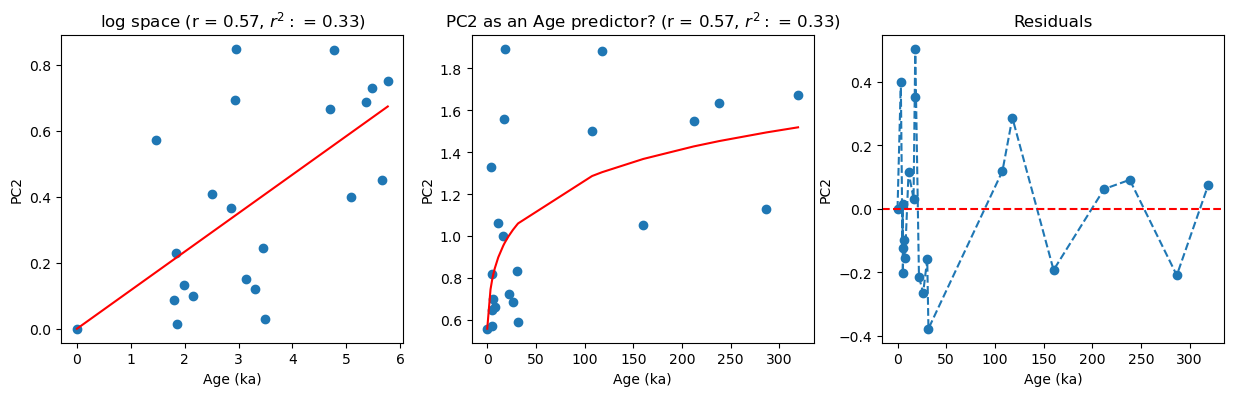

In [761]:
# Fit Power law function and take resiudals (without 0)
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
# data
PC1 = np.array(target_PC)
PC1_posative = (PC1 - PC1.min()) + 1 # scale PC1 to remove negatives, and add 1 to compute log(0) as 0
age_log = age + 1   # add 1 to compute log(0) as 0

# take natural log
age_log = np.log(age_log) 
PC1_log = np.log(PC1_posative)

# run linear regression
X = age_log.reshape(-1,1) # values converts it into a numpy array
Y = PC1_log.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_pred_unpacked = Y_pred_unpacked - 1
Y_pred_unpacked = Y_pred_unpacked + PC1.min() 

Y_unpacked = (np.exp(Y))
Y_unpacked = Y_unpacked - 1
Y_unpacked = Y_unpacked + PC1.min()

X_unpacked = (np.exp(X)) - 1

# correlation coefficient (r^2)
#r2 = r2_score(Y, Y_pred)
#r2 = round(r2,2)

rho, p = spearmanr(Y, Y_pred)
rho2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Age (ka)')
plt.ylabel('PC2')
plt.title('log space (r = {}, $r^2:$ = {})'.format(np.round(rho,2),np.round(rho2,2)))

plt.subplot(1,3,2)
plt.scatter(X_unpacked, Y_unpacked)
plt.plot(X_unpacked, Y_pred_unpacked, color='red')
#plt.errorbar(X_unpacked, Y_unpacked, xerr=age_sd, yerr = target_PC_std, fmt='o')
plt.xlabel('Age (ka)')
plt.ylabel('PC2')
plt.title('PC2 as an Age predictor? (r = {}, $r^2:$ = {})'.format(np.round(rho,2),np.round(rho2,2)))


plt.subplot(1,3,3)
plt.scatter(X_unpacked, residuals)
plt.plot(X_unpacked, residuals, linestyle = '--')
plt.axhline(y=0.0, color='r', linestyle='--')
plt.xlabel('Age (ka)')
plt.ylabel('PC2')
plt.title('Residuals')

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(B,A))

print('Power funtion: y = {}x^{}'.format(A_pl,B))

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(X_unpacked, Y_unpacked)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.errorbar(X_unpacked, Y_unpacked, xerr=age_sd, yerr = target_PC_std, fmt='o')
plt.xlabel('Age (ka)')
plt.ylabel('PCx')
plt.title(sensor + ' PCx; an Age predictor? ($r^2:$ {})'.format(round(rho**2,2)))

plt.subplot(1,2,2)
plt.scatter(X_unpacked, residuals)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('Residuals'.format(rho**2))


In [44]:
# long term dO18 record
# import data
from numpy import linspace, loadtxt, ones, convolve

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# prep data
O18_global = pd.read_csv('O18_global_karner2002.csv', header = 0)
O18_global = O18_global.rename(columns={O18_global.columns[0]: "age", O18_global.columns[1]: 'dO18'})
O18_global = O18_global.replace({999:np.NaN})

#O18_global = O18_global.reset_index(drop = True) # reset row index
#O18_global['dO18'] = O18_global['dO18'] * -1 # inverse the data 

age_fans = age[age >= 0] # fans with age > 0 

ice_proxy = O18_global.loc[O18_global['age'] >= 0]#(age_fans.min()- 1)] # paleo data with age > 0 
ice_proxy = ice_proxy.loc[ice_proxy['age'] <= max(age_fans)] # paleo data with age < max age chosen
age_proxy = np.array(ice_proxy['age']).reshape(1,-1)[0]

#fans = residuals[0:]
fans = target_PC[0:]
#fans = ((y_rec.T[191]/y_rec.T[143])*-1)[1:]
#fans = y_rec_ratio[1:]
# normalize each dataset
#ice_proxy['dO18'] = (ice_proxy['dO18'] - ice_proxy['dO18'].mean())/ice_proxy['dO18'].std()
#fans = (fans - fans.mean())/fans.std()
 

from sklearn.preprocessing import MinMaxScaler
ice_proxy = np.array(ice_proxy['dO18']).reshape(-1,1)
ice_proxy = MinMaxScaler().fit_transform(ice_proxy)
ice_proxy = ice_proxy.reshape(1,-1)[0]
fans = MinMaxScaler().fit_transform(fans.reshape(-1,1))
fans = fans.reshape(1,-1)[0]

target_PC_std_proxy = target_PC_std_matrix[0:] * np.abs(fans.max()) # apply std matrix


NameError: name 'target_PC_std_matrix' is not defined

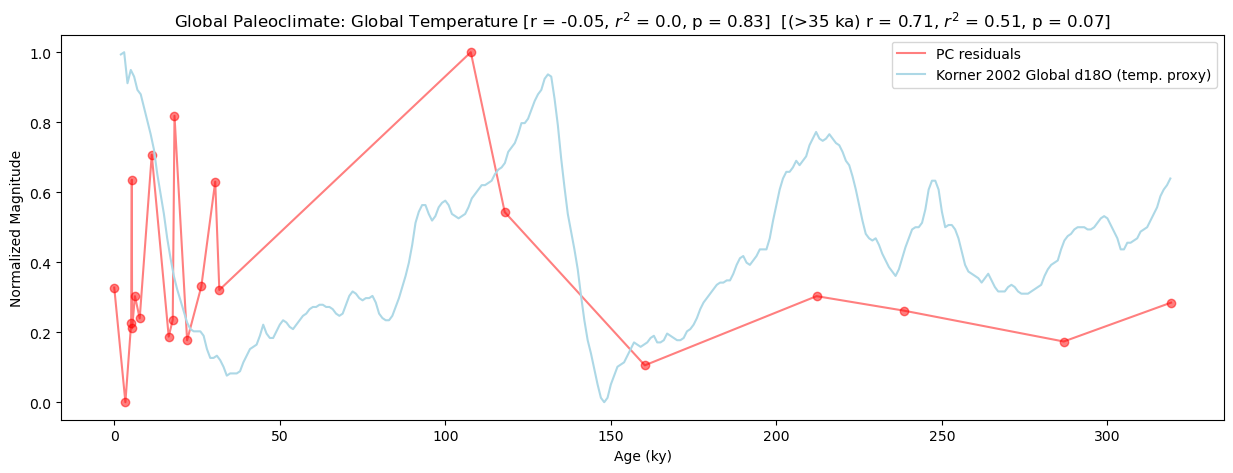

In [45]:
pre_lgm_idx = np.min(np.where(age > 35)) # minimm index location depicting pre-lgm i.e. before precip record

# Plot
# correlation coefficient (r --> r^2)
fan_pts = np.interp(age_proxy, age_fans, fans) # interpolated PC value at each proxy age point
ice_proxy_pts = np.interp(age_fans, age_proxy, ice_proxy) #  interpolated proxy value at each fan age point

x_values = fans[1:]
y_values = ice_proxy_pts[1:]
rho_all, p_all = pearsonr(x_values, y_values)

x_values = fans[pre_lgm_idx:]
y_values = ice_proxy_pts[pre_lgm_idx:]
rho_pre_lgm, p_pre_lgm = spearmanr(x_values, y_values)


plt.figure(figsize = (15,5))
plt.scatter(age_fans, fans, color = 'red', alpha = 0.5) # residual data 
plt.plot(age_fans, fans, color = 'red', alpha = 0.5, label = 'PC residuals')
#plt.errorbar(age_fans, fans, xerr=age_sd[0:], yerr = target_PC_std_proxy, alpha = 0.5, c ='red', fmt='-o')
#plt.errorbar(age_fans, fans, xerr=age_sd[0:], alpha = 0.5, c ='red', fmt='-o')

plt.plot(age_proxy, ice_proxy, color = 'lightblue', alpha = 1,label = 'Korner 2002 Global d18O (temp. proxy)')
plt.title('Paleoclimate (dO18 Global temp. proxy')
plt.xlabel('Age (ky)')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.xlim()
plt.title('Global Paleoclimate: Global Temperature [r = {}, $r^2 $ = {}, p = {}]  [(>35 ka) r = {}, $r^2 $ = {}, p = {}]'.format(round(rho_all,2),round(rho_all**2,2),round(p_all,2), round(rho_pre_lgm,2), round(rho_pre_lgm**2,2),round(p_pre_lgm,2)))
plt.show()

In [1108]:
age

array([  0.  ,   3.37,   5.11,   5.3 ,   5.4 ,   6.25,   7.69,  11.33,
        16.45,  17.67,  18.2 ,  22.01,  26.3 ,  30.5 ,  31.74, 107.7 ,
       117.95, 160.26, 212.15, 238.47, 286.8 , 319.22])

,age,dO18
0,0.42,-3.35
1,0.64,-3.35
2,0.85,-3.51
3,1.06,-3.37
4,1.28,-3.44
...,...,...
95,32.79,-3.82
96,33.03,-4.06
97,33.27,-3.77
98,33.51,-3.25


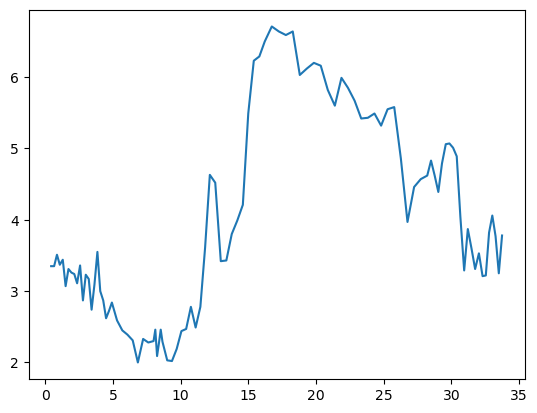

In [46]:
# Prepare and trim data to ~LGM
# O18 proxy plot
O18 = pd.read_csv('O18_Wang_etal_2007.csv', header = 0)
O18 = O18.rename(columns={'Age (ky B.P.)': "age", 'd18O (per mil, VPDB)': "dO18"})
O18['dO18'] = O18['dO18'] * -1 # inverse the data (so it plots like precip i.e. high value is high precip)
O18.head()

max_age = 35# Ka

age_fans_precip = age[age >= 0] # fans with age > 0 
age_fans_precip = age_fans_precip[age_fans_precip <= max_age] # fans with age < max age chosen

precip_proxy = O18.loc[O18['age'] >= age_fans_precip.min()] # paleo data with age > 0 
precip_proxy = precip_proxy.loc[precip_proxy['age'] <= max_age] # paleo data with age < max age chosen
age_precip_proxy = np.array(precip_proxy['age']).reshape(1,-1)[0]

#fans_precip = residuals[0:len(age_fans_precip)]
fans_precip = target_PC[0:len(age_fans_precip)]
#fans_precip = ((data[191]/data[143])*-1)[1:len(age_fans_precip)+ 1] #zhao ratio
#fans_precip = y_rec_ratio[1:len(age_fans_precip)+ 1]

# normalize each dataset
precip_proxy = np.array(precip_proxy['dO18']).reshape(-1,1)
precip_proxy = MinMaxScaler().fit_transform(precip_proxy)
precip_proxy = precip_proxy.reshape(1,-1)[0]
fans_precip = MinMaxScaler().fit_transform(fans_precip.reshape(-1,1))
fans_precip = fans_precip.reshape(1,-1)[0]

#target_PC_std_proxy_precip = target_PC_std_matrix[1:len(age_fans_precip)+1] * np.abs(fans.max()) # apply std matrix

#extract corresponding O18 (y) values @ PC1 age (PC1 X locations)
precip_proxy_pts = np.interp(age_fans_precip, age_precip_proxy, precip_proxy) # extract proxy points for every age value 
fans_precip_pts = np.interp(age_proxy, age_fans_precip, fans_precip) # extract points for every proxy value

Text(0.5, 1.0, 'Regional Paleoclimate (precipitation): r = -0.24, $r^2 $ = 0.06, p = 0.4568')

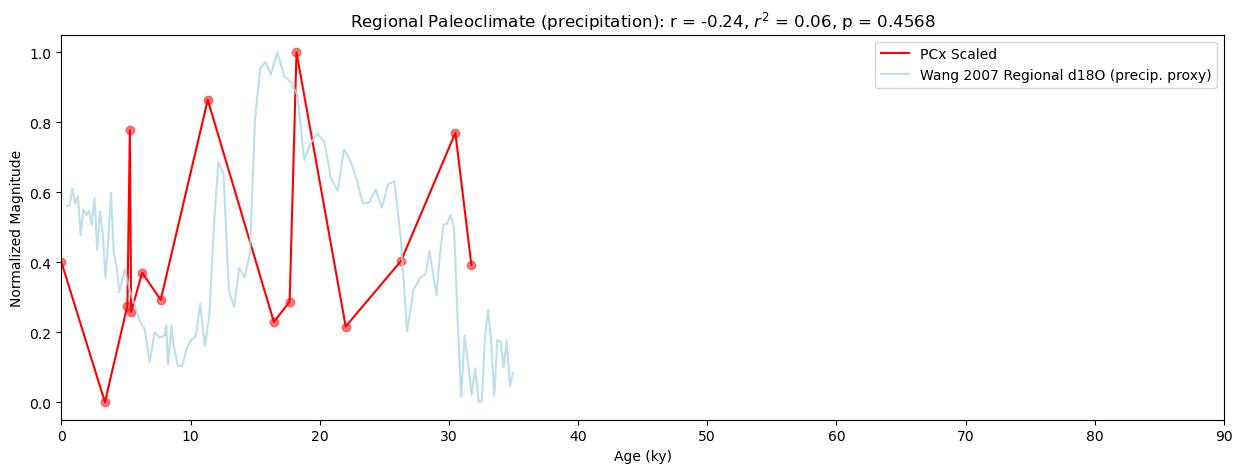

In [47]:
# plot paleoclimate data against PCx
# correlation coefficient
x_values = fans_precip[3:]
y_values = precip_proxy_pts[3:] # correlation to approximetly 35ka
rho_precip, p_precip = spearmanr(x_values, y_values)

# Plot
plt.figure(figsize = (15,5))
plt.scatter(age_fans_precip, fans_precip, color = 'red', alpha = 0.5) # residual data 
plt.plot(age_fans_precip, fans_precip, color = 'red', label = 'PCx Scaled')
#plt.errorbar(age_fans_precip, fans_precip, xerr=age_sd[0:len(age_fans_precip)], yerr = target_PC_std_proxy_precip, c ='red', fmt='-o', alpha = 0.7)
#plt.errorbar(age_fans_precip, fans_precip, xerr=age_sd[1:len(age_fans_precip)+1],c ='red', fmt='-o', alpha = 0.7)

plt.plot(age_precip_proxy, precip_proxy, color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
plt.title('Paleoclimate (dO18 Global temp. proxy', size = 12)
plt.xlabel('Age (ky)', size = 10)
plt.ylabel('Normalized Magnitude', size = 10)
plt.legend()
plt.xlim(0,90)
plt.title('Regional Paleoclimate (precipitation): r = {}, $r^2 $ = {}, p = {}'.format(round(rho_precip,2), round(rho_precip**2,2), round(p_precip,4)))

ValueError: The lengths of the data (19) and the error 17 do not match

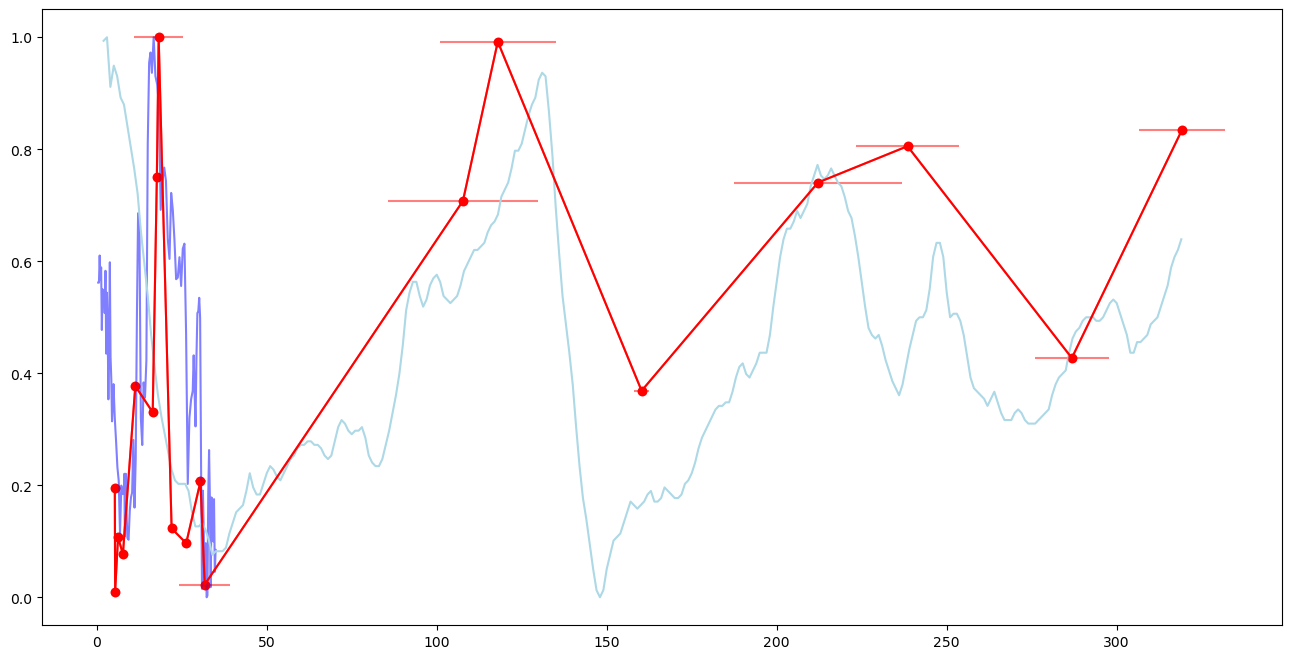

In [766]:
plt.figure(figsize = (16,8))
plt.plot(age_precip_proxy, precip_proxy, color = 'blue', alpha =.5 ,label = 'Scaled regional monsoon proxy (Wang et al., 2007)')
plt.plot(age_proxy, ice_proxy, color = 'lightblue', alpha = 1, label = 'Scaled global temperature dO18 proxy (Korner et al., 2002)')
plt.plot(age[3:], fans[3:], c = 'red')
plt.scatter(age[3:],fans[3:], c = 'red', label = 'PC1 Scores (weathering intensity)')
plt.errorbar(age_fans[3:], fans[3:], xerr=age_sd[3:], yerr = target_PC_std_proxy[3:], alpha = 0.5, c ='red', fmt='-o')
plt.xlabel('Normalized Values (0 to 1)')
plt.ylabel('Age (ky)')
plt.legend()
plt.xlim()

plt.title('Alluvial Fan Weathering Signal: [Regional monsoon record: $r^2 $ = {}, p = {}] [Global temperature record: $r^2 $ = {}, p = {}]'.format(round(rho_precip**2,2), round(p_precip,4), round(rho_pre_lgm**2,2), round(rho_pre_lgm,2)))


In [767]:
# long term dO18 record
# import data
from numpy import linspace, loadtxt, ones, convolve

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# prep data
O18_global = pd.read_csv('O18_global_karner2002.csv', header = 0)
O18_global = O18_global.rename(columns={O18_global.columns[0]: "age", O18_global.columns[1]: 'dO18'})
O18_global = O18_global.replace({999:np.NaN})

#O18_global = O18_global.reset_index(drop = True) # reset row index
#O18_global['dO18'] = O18_global['dO18'] * -1 # inverse the data 

age_fans = age[age >= 0] # fans with age > 0 

ice_proxy = O18_global.loc[O18_global['age'] >= 0]#(age_fans.min()- 1)] # paleo data with age > 0 
ice_proxy = ice_proxy.loc[ice_proxy['age'] <= max(age_fans)] # paleo data with age < max age chosen

age_proxy = np.array(ice_proxy['age']).reshape(1,-1)[0]
ice_proxy = np.array(ice_proxy['dO18']).reshape(-1,1)
ice_proxy = ice_proxy.reshape(1,-1)[0]

 
#fans = residuals[0:]
fans = target_PC[0:]
#target_PC_std_proxy = target_PC_std_matrix[0:] * np.abs(fans.max()) # apply std matrix


# PRECIP RECORD
# Prepare and trim data to ~LGM
# O18 proxy plot
O18 = pd.read_csv('O18_Wang_etal_2007.csv', header = 0)
O18 = O18.rename(columns={'Age (ky B.P.)': "age", 'd18O (per mil, VPDB)': "dO18"})
O18['dO18'] = O18['dO18'] # inverse the data (so it plots like precip i.e. high value is high precip)
O18.head()

max_age = 35# Ka

age_fans_precip = age[age >= 0] # fans with age > 0 
age_fans_precip = age_fans_precip[age_fans_precip <= max_age] # fans with age < max age chosen

precip_proxy = O18.loc[O18['age'] >= age_fans_precip.min()] # paleo data with age > 0 
precip_proxy = precip_proxy.loc[precip_proxy['age'] <= max_age] # paleo data with age < max age chosen
age_precip_proxy = np.array(precip_proxy['age']).reshape(1,-1)[0]

#fans_precip = residuals[0:len(age_fans_precip)]
fans_precip = target_PC[0:len(age_fans_precip)]

# normalize each dataset
precip_proxy = np.array(precip_proxy['dO18']).reshape(1,-1)[0]

fans_precip = fans_precip.reshape(1,-1)[0]

#target_PC_std_proxy_precip = target_PC_std_matrix[1:len(age_fans_precip)+1] * np.abs(fans.max()) # apply std matrix

#extract corresponding O18 (y) values @ PC1 age (PC1 X locations)
precip_proxy_pts = np.interp(age_fans_precip, age_precip_proxy, precip_proxy) # extract proxy points for every age value 
fans_precip_pts = np.interp(age_proxy, age_fans_precip, fans_precip) # extract points for every proxy value

No handles with labels found to put in legend.


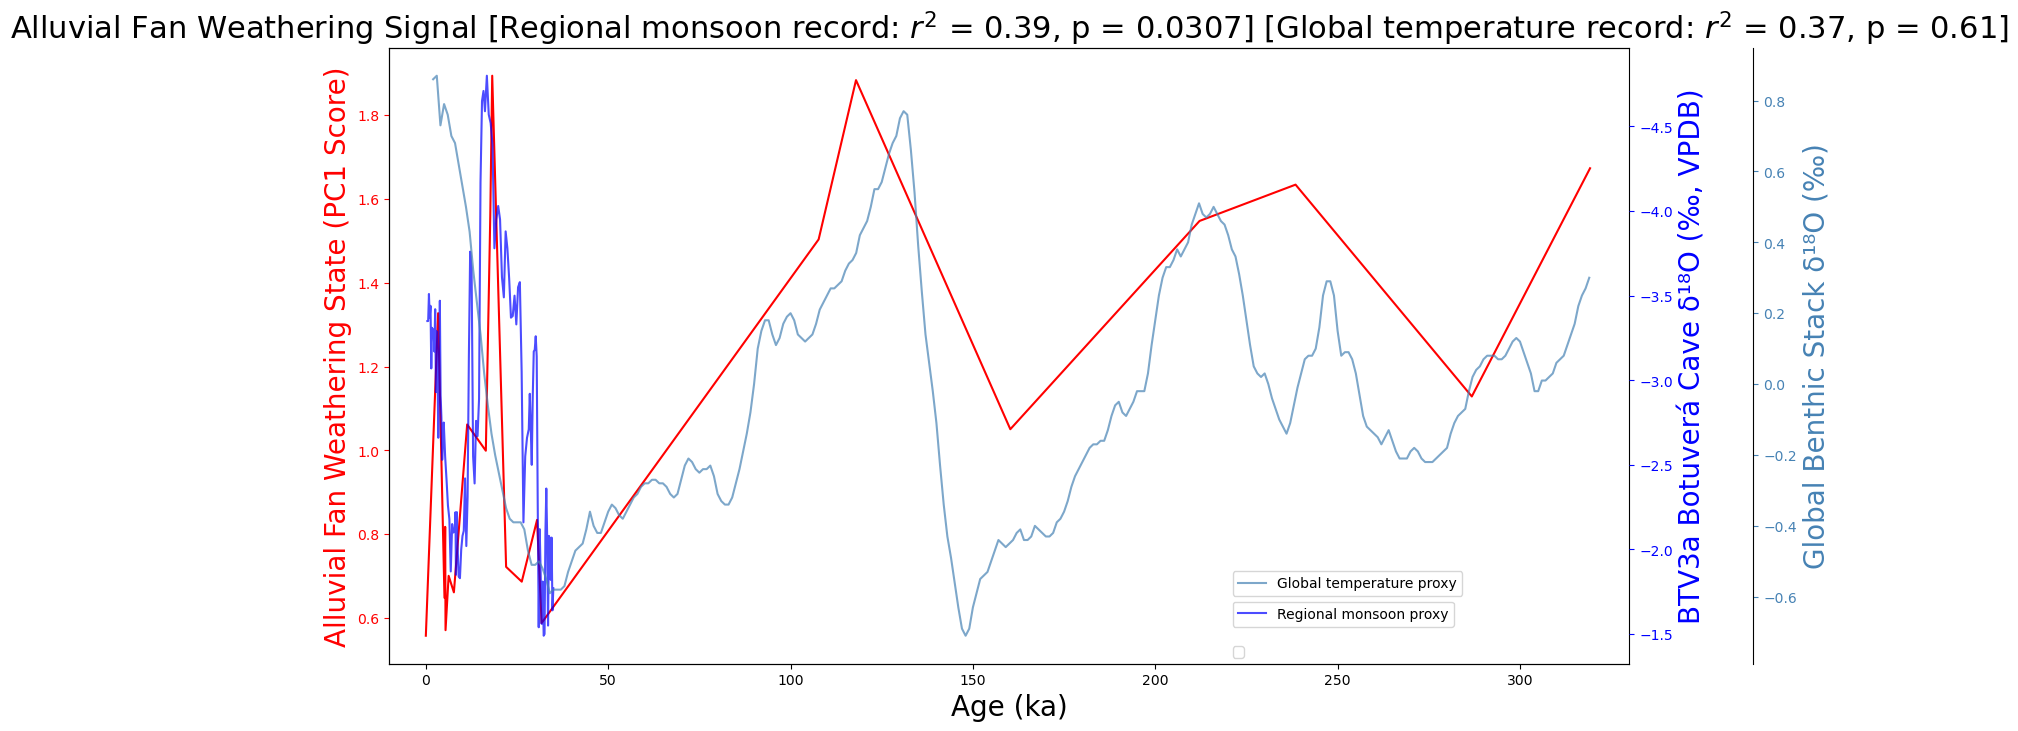

In [768]:
import matplotlib.pyplot as plt

x_values1=age[0:]
y_values1=fans[0:]
c1 = 'red'

x_values2=age_precip_proxy
y_values2=precip_proxy
c2 = 'blue'

x_values3= age_proxy
y_values3= ice_proxy
c3 = 'steelblue'




xmin = -10
xmax = 330

fig=plt.figure(figsize = (16,8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax3=fig.add_subplot(111, label="3", frame_on=True)
ax3.patch.set_visible(False)


ax.plot(x_values1, y_values1, color=c1)
ax.set_xlim(left = xmin, right=xmax)
#ax.errorbar(x_values1, y_values1, xerr=age_sd[3:], yerr = target_PC_std_proxy[3:], alpha = 0.5, c ='red', fmt='-o', label = 'PC1 Scores (weathering intensity)')
ax.set_xlabel('Age (ka)', color='black', size = 20)
ax.set_ylabel('Alluvial Fan Weathering State (PC1 Score)', color=c1, size = 20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors=c1)

ax2.plot(x_values2, y_values2, color=c2, alpha = 0.7, label = 'Regional monsoon proxy')
ax2.set_xlim(left = xmin, right=xmax)
ax2.set_xticks([])
ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax2.set_ylabel('BTV3a Botuverá Cave δ¹⁸O (‰, VPDB)', color=c2, size = 20)       
#ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax2.tick_params(axis='y', colors=c2)
ax2.invert_yaxis()

ax3.plot(x_values3, y_values3, color=c3, alpha = 0.7, label = 'Global temperature proxy')
ax3.set_xlim(left = xmin, right=xmax)
ax3.set_xticks([])
ax3.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax3.set_ylabel('Global Benthic Stack δ¹⁸O (‰)', color=c3, size =20)
#ax2.xaxis.set_label_position('top') 
ax3.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax3.tick_params(axis='y', colors=c3)
ax3.spines['right'].set_position(('axes', 1.1))

ax.legend(loc = [.68,.01])
ax2.legend(loc = [.68,.06])
ax3.legend(loc = [.68,.11])

plt.title('Alluvial Fan Weathering Signal [Regional monsoon record: $r^2 $ = {}, p = {}] [Global temperature record: $r^2 $ = {}, p = {}]'.format(round(rho_precip**2,2), round(p_precip,4), round(rho_pre_lgm**2,2), round(rho_pre_lgm,2)), size = 22)

plt.show()

In [49]:
## LOAD PALEO PROXIES ##

# Global O18 record (benthic stack from Karner 2002)
O18_global = pd.read_csv('O18_global_karner2002.csv', header = 0)
O18_global = O18_global.rename(columns={O18_global.columns[0]: "age", O18_global.columns[1]: 'dO18'})
O18_global = O18_global.replace({999:np.NaN})
O18_global = O18_global[0:340]
age_proxy = np.array(O18_global['age'])
ice_proxy = np.array(O18_global['dO18'])

# load precip proxy (Wang et al. 2007 BTV3 Spelothem, corrected by M'Darcy using Baker and Fritz 2015 method)
O18 = pd.read_csv('Baker and Fritz correction of d18O records.csv', header = 0)
O18 = O18.rename(columns={'Age (ky B.P.)': "age", 'Corrected d18O': "dO18"})
#O18 = O18[0:100]
age_precip_proxy = np.array(O18['age'])
precip_proxy = np.array(O18['dO18'])

# insolation cycle at 30*S (annual average made by M'Darcy using [http://vo.imcce.fr/insola/earth/online/earth/online/index.php])
insolation = pd.read_csv('insolation_30s_avg_mitch.csv', header = 0)
insolation = insolation.rename(columns={insolation.columns[0]: "age", insolation.columns[1]: 'wm2'})
insolation = np.array(insolation).astype(float)
ins_age = insolation[:,0]
ins = insolation[:,1]

ins_pts = np.interp(age, ins_age, ins) # extract proxy points for every age value 
rho_ins, p_ins = spearmanr(fans, ins_pts)
print(np.round(rho_ins**2,3), np.round(p_ins**2,3)) # print r2 and p value between PCs and isolation

0.04 0.14


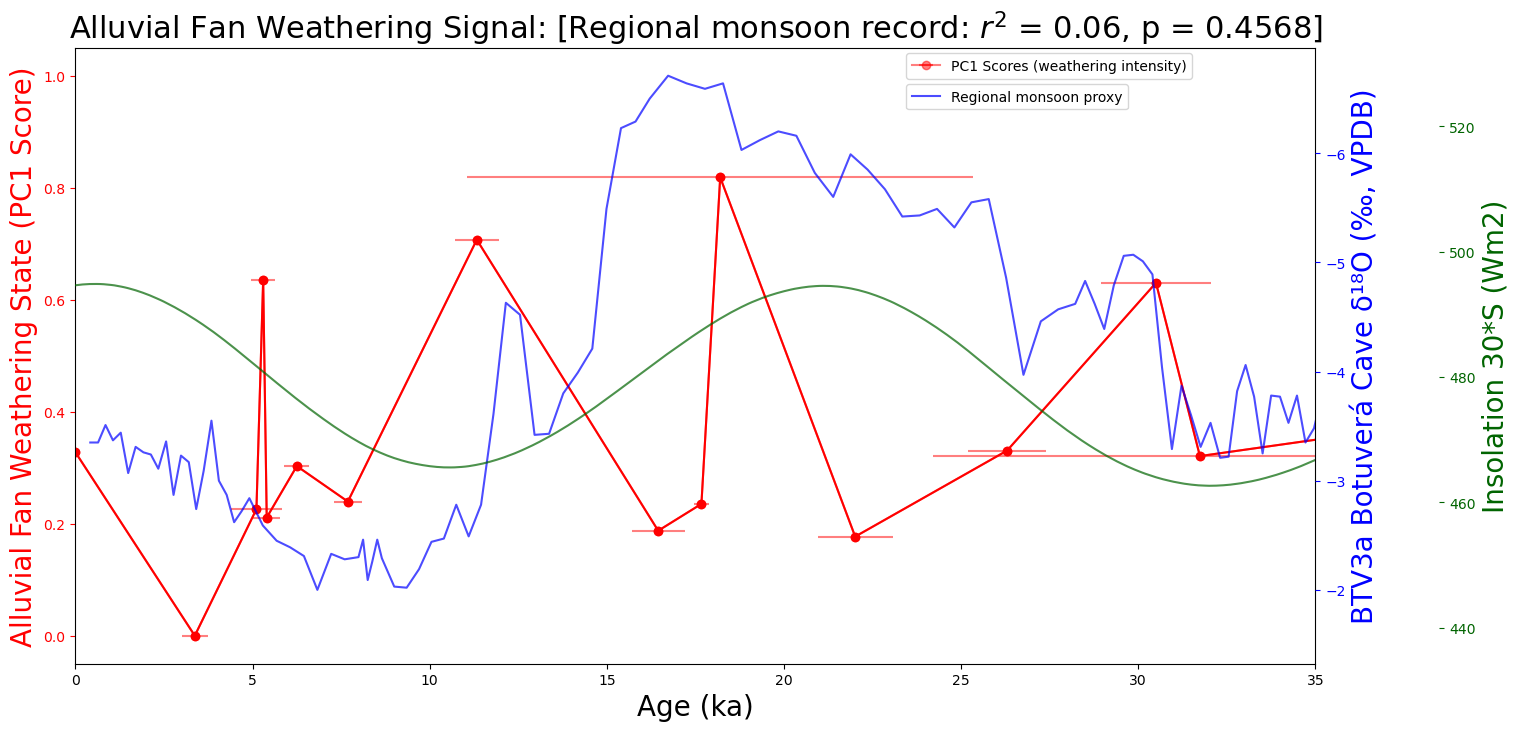

In [50]:
import matplotlib.pyplot as plt
starting_age_idx = 0

x_values1=age[starting_age_idx:]
y_values1=fans[starting_age_idx:]
c1 = 'red'

x_values2=age_precip_proxy
y_values2=precip_proxy
c2 = 'blue'

x_values4= ins_age
y_values4= ins
c4 = 'darkgreen'

xmin = 0
xmax = 35

fig=plt.figure(figsize = (16,8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax4=fig.add_subplot(111, label="2", frame_on=False)


ax.plot(x_values1, y_values1, color=c1)
ax.set_xlim(left = xmin, right=xmax)
ax.scatter(x_values1, y_values1, color=c1)
ax.errorbar(x_values1, y_values1, xerr=age_sd[starting_age_idx:], alpha = 0.5, c ='red', fmt='-o', label = 'PC1 Scores (weathering intensity)')
ax.set_xlabel("Age (ka)", color='black', size = 20)
ax.set_ylabel("Alluvial Fan Weathering State (PC1 Score)", color=c1, size = 20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors=c1)

ax2.plot(x_values2, y_values2, color=c2, alpha = 0.7, label = 'Regional monsoon proxy')
ax2.set_xlim(left = xmin, right=xmax)
ax2.set_xticks([])
ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax2.set_ylabel('BTV3a Botuverá Cave δ¹⁸O (‰, VPDB)', color=c2, size = 20)       
#ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax2.tick_params(axis='y', colors=c2)
ax2.invert_yaxis()
ax.legend(loc = [.67,.95])
ax2.legend(loc = [.67,.9])

ax4.plot(x_values4, y_values4, color=c4, alpha = 0.7, label = 'Insolation 30*S')
ax4.set_xlim(left = xmin, right=xmax)
ax4.set_xticks([])
ax4.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax4.set_ylabel('Insolation 30*S (Wm2)', color=c4, size =20)
#ax2.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax4.tick_params(axis='y', colors=c4)
ax4.spines['right'].set_position(('axes', 1.1))

plt.title('Alluvial Fan Weathering Signal: [Regional monsoon record: $r^2 $ = {}, p = {}]'.format(round(rho_precip**2,2), round(p_precip,4)), size = 22)

plt.show()

In [715]:
age

array([  0.  ,   5.11,   5.3 ,   5.4 ,   7.69,  11.33,  16.45,  17.67,
        18.2 ,  22.01,  26.3 ,  30.5 ,  31.74, 107.7 , 117.95, 160.26,
       212.15, 238.47, 286.8 , 319.22])

NameError: name 'target_PC_std_proxy' is not defined

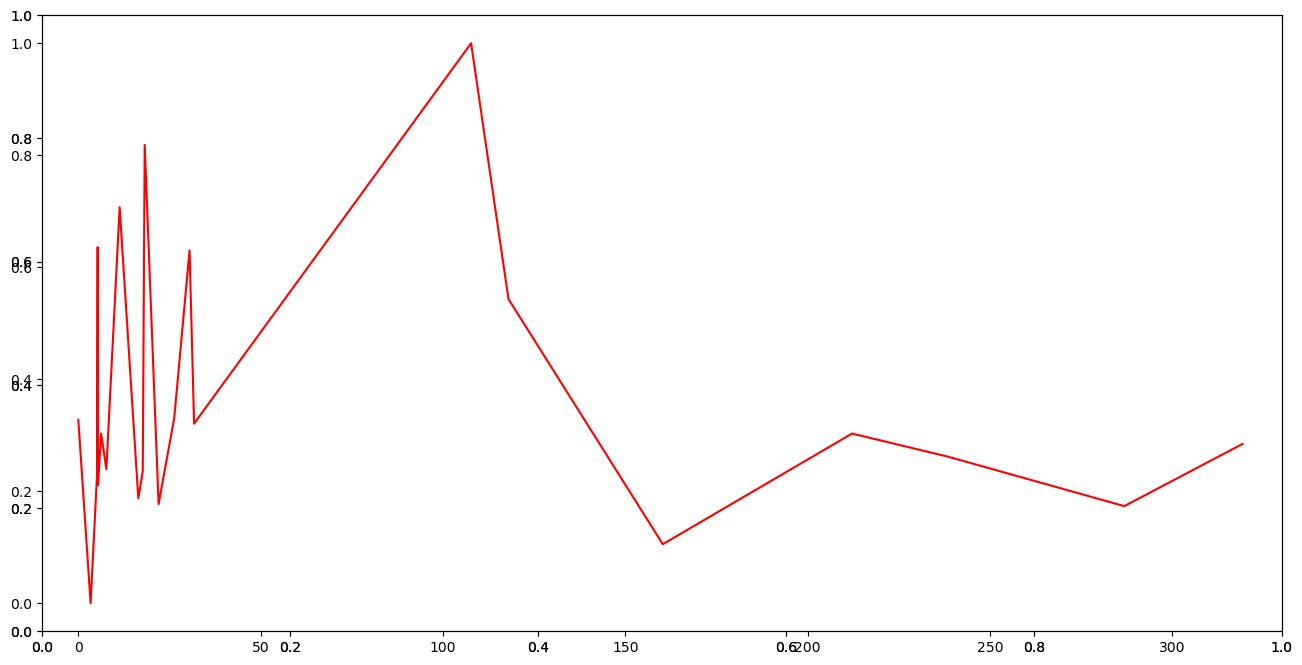

In [51]:
import matplotlib.pyplot as plt
starting_age_idx = 0

x_values1=age[starting_age_idx:]
y_values1=fans[starting_age_idx:]
c1 = 'red'

x_values2=age_precip_proxy
y_values2=precip_proxy
c2 = 'blue'

x_values3= age_proxy
y_values3= ice_proxy
c3 = 'steelblue'

x_values4= ins_age
y_values4= ins
c4 = 'darkgreen'

xmin = -10
xmax = 330

fig=plt.figure(figsize = (16,8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax3=fig.add_subplot(111, label="3", frame_on=True)
#ax4=fig.add_subplot(111, label="4", frame_on=False)

ax3.patch.set_visible(False)


ax.plot(x_values1, y_values1, color=c1)
ax.set_xlim(left = xmin, right=xmax)
ax.errorbar(x_values1, y_values1, xerr=age_sd[starting_age_idx:], yerr = target_PC_std_proxy[starting_age_idx:], alpha = 0.5, c ='red', fmt='-o', label = 'PC1 Scores (weathering intensity)')
ax.set_xlabel('Age (ka)', color='black', size = 20)
ax.set_ylabel('Alluvial Fan Weathering State (PC1 Score)', color=c1, size = 20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors=c1)

ax2.plot(x_values2, y_values2, color=c2, alpha = 0.7, label = 'Regional monsoon proxy')
ax2.set_xlim(left = xmin, right=xmax)
ax2.set_xticks([])
ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax2.set_ylabel('BTV3a Botuverá Cave δ¹⁸O (‰, VPDB)', color=c2, size = 20)       
#ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax2.tick_params(axis='y', colors=c2)
ax2.invert_yaxis()

ax3.plot(x_values3, y_values3, color=c3, alpha = 0.7, label = 'Global temperature proxy')
ax3.set_xlim(left = xmin, right=xmax)
ax3.set_xticks([])
ax3.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax3.set_ylabel('Global Benthic Stack δ¹⁸O (‰)', color=c3, size =20)
#ax2.xaxis.set_label_position('top') 
ax3.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax3.tick_params(axis='y', colors=c3)
ax3.spines['right'].set_position(('axes', 1.1))

ax4.plot(x_values4, y_values4, color=c4, alpha = 0.7, label = 'Insolation 30*S')
ax4.set_xlim(left = xmin, right=xmax)
ax4.set_xticks([])
ax4.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax4.set_ylabel('Insolation 30*S (Wm2)', color=c4, size =20)
#ax2.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax4.tick_params(axis='y', colors=c4)
ax4.spines['right'].set_position(('axes', 1.1))

ax.legend(loc = [.68,.01])
ax2.legend(loc = [.68,.06])
ax3.legend(loc = [.68,.11])
ax4.legend(loc = [.68,.16]) 


plt.title('Alluvial Fan Weathering Signal [Regional monsoon record: $r^2 $ = {}, p = {}] [Global temperature record: $r^2 $ = {}, p = {}]'.format(round(rho_precip**2,2), round(p_precip,4), round(rho_pre_lgm**2,2), round(rho_pre_lgm,2)), size = 22)

plt.show()

### MLR to predict precip (monsoon)

In [772]:
# MLR model using climate to predict PCs i.e. weathering state
#import all required libraries etc

from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import StandardScaler

x1 = np.array(PCs[:,2])
#x1 = residuals[0:]
x1 = (x1 - x1.min()) + .0001 # scale PC1 to remove negatives, and add 1 to compute log(0) as 0
x2 = np.array(ice_proxy_pts)
x3 = np.array(ins_pts)
x4 = np.array(age)
x5 = np.array(PCs[:,1]/age)
x5[0] = np.nan


X_all = pd.DataFrame({'x1':np.log(x1),
                      'x2':np.log(x2),
                      'x3':np.log(x3), 
                   })


X_all = StandardScaler().fit_transform(X_all)
X_train = X_all[1:13]
X_new = X_all[14:]

y_train = np.array(precip_proxy_pts[1:]) 

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X_train,y_train)
ypred_MLR = lm_MLR.predict(X_train) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X_train,y_train) #R-squared value from MLR model


print('MLR results:')
print('r2 = ' + str(R2_MLR))
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
print('a2 = ' + str(coef_MLR[1]))
#print('a3 = ' + str(coef_MLR[2]))
#print('a4 = ' + str(coef_MLR[3]))

#print('etc...')
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(y_train, ypred_MLR, c = age[1:13], label = age[1:13])
plt.xlabel('y')
plt.ylabel('y_pred')
plt.title('model results')

plt.subplot(122)
plt.axhline(y=0, color='r', linestyle='--')
plt.scatter(age[1:13], (ypred_MLR-y_train))
plt.ylim(-2,2)
plt.legend()
plt.xlabel('age (ka)')
plt.xlabel('residual')
plt.title('residual plot')


C:\Users\htccr\AppData\Local\Temp\ipykernel_55924\1941404417.py:19: RuntimeWarning: divide by zero encountered in true_divide
  x5 = np.array(PCs[:,1]/age)


ValueError: Found input variables with inconsistent numbers of samples: [12, 14]

(0.0, 350.0)

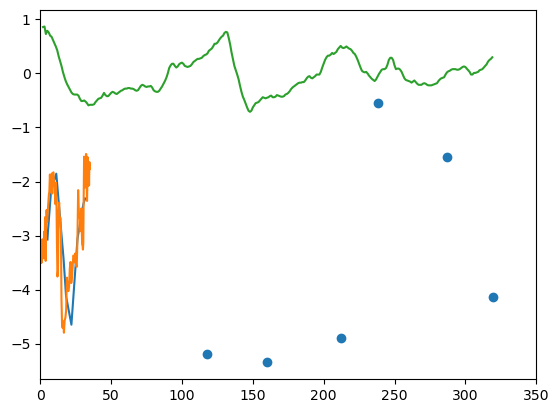

In [702]:
# predict
ypred_new = lm_MLR.predict(X_new) 

#plt.scatter(x4_new, ypred_new)
plt.scatter(age[14:], ypred_new)
plt.plot(age[1:13],ypred_MLR)
plt.plot(age_precip_proxy, precip_proxy)
plt.plot(age_proxy, ice_proxy)

plt.xlim(0,350)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

# Create toy data 
x = np.linspace(0, 10, 20)
y = x + (np.random.rand(len(x)) * 10)

# Extend x data to contain another row vector of 1s
X = np.vstack([x, np.ones(len(x))]).T

n_estimators = 50
model = BaggingRegressor(LinearRegression(), 
                         n_estimators=n_estimators,
                         bootstrap=True)

model.fit(X, y)

plt.figure(figsize=(12,8))

# Accessing each base_estimator (already fitted)
for m in model.estimators_:
    plt.plot(x, m.predict(X), color='grey', alpha=0.2, zorder=1)

plt.scatter(x,y, marker='o', color='orange', zorder=4)

# "Bagging model" prediction
plt.plot(x, model.predict(X), color='red', zorder=5)

### Reconstruct dataset using n PCs

In [1158]:
pc = 0

# reconstruct data usin x PC
# y(t) - mean(y(t)) = sum(PC_j(t)*e_j)
# y(t) = sum(PC_j(t)*e_j) + mean(y(t))
# y(t) - mean(y(t)) / sum(e_j) = sum(PC_j(t)) <-- to project new data into PC space?
mean_y = np.mean(data,axis=0)
#test = np.array([PCs[jj,0]*eigvecs[0] + mean_y[jj] for jj in range(24)])
y_rec = np.array([PCs[jj,pc]*eigvecs[pc] + PCs[jj,1]*eigvecs[1] + mean_y for jj in range(len(age))]) # + mean_y, or mean[jj] , or none
y_rec = pd.DataFrame(y_rec)

In [ ]:
pc = 1

# reconstruct data usin x PC
# y(t) - mean(y(t)) = sum(PC_j(t)*e_j)
# y(t) = sum(PC_j(t)*e_j) + mean(y(t))
# y(t) - mean(y(t)) / sum(e_j) = sum(PC_j(t)) <-- to project new data into PC space?
mean_y = np.mean(data,axis=0)
#test = np.array([PCs[jj,0]*eigvecs[0] + mean_y[jj] for jj in range(24)])
y_rec = np.array([PCs[jj,pc]*eigvecs[pc] + mean_y for jj in range(len(age))]) # + mean_y, or mean[jj] , or none
y_rec = pd.DataFrame(y_rec)

In [ ]:
# apply if standardization was completed earlier
# normalize each observation to have the same mean & std
y_rec[bad_band_idx] = np.nan
y_rec = (y_rec *data.std())+ data.mean()

In [ ]:
# normalize to a particular band (i.e. to Band 1 as zero), scale all observation 0 - 1 
y_rec = (y_rec -  y_rec.loc[0]) # choose band as zero point
max_all = y_rec.max().max()
min_all = y_rec.min().min()
y_rec = (y_rec - min_all)/(max_all - min_all) 
y_rec = y_rec

In [ ]:
# normalize each observation to have the same mean & std
y_rec = (y_rec - y_rec.mean())/y_rec.std()
y_rec = y_rec

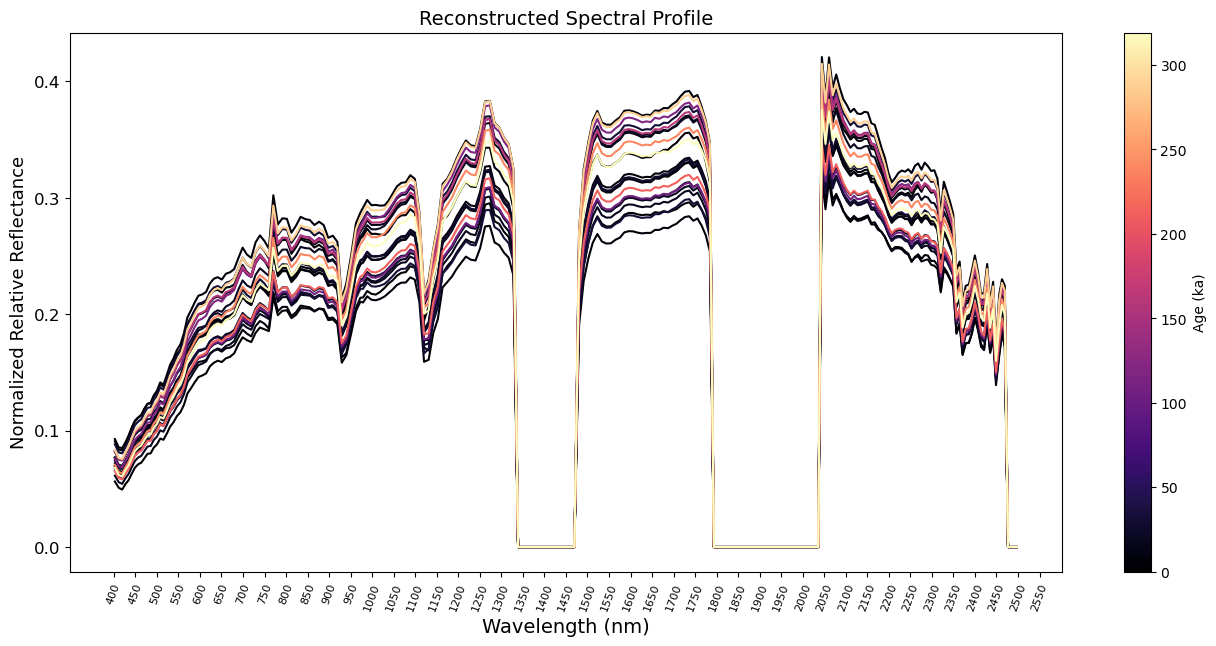

In [1159]:
norm = plt.Normalize(vmin=min(age), vmax=max(age))

target_x = nm_names
target_y = y_rec
target_names = age

N = len(target_names) # number of objects to plot i.e. color cycle count

fig, ax = plt.subplots(figsize = (16,7))
#for i in range(N):
    #ax.plot(target_x, target_y.iloc[i], label = target_names[i]) # for i in range of objects, plot x,y
for i in range(N): 
    ax.plot(target_x, target_y.iloc[i],label = target_names[i], color=plt.cm.magma(norm(age[i])))
#axes
#plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.xticks(np.arange(400, 2600, 50), fontsize = 10, rotation=70, size = 8)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xlabel('Wavelength (nm)', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel('Normalized Relative Reflectance', fontsize = 13)
plt.title("Reconstructed Spectral Profile", size = 14)
plt.title
plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

# legend location (if using discrete line key)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0 + box.height * 0.1,
                # box.width, box.height * .9])

#ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          #fancybox=True, shadow=True, ncol=1, title = 'Age (ky)') # Put a legend below current axis
plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()


In [ ]:
PC_scaled = np.array(PCs[:,1])
PC_scaled = (PC_scaled - np.min(PC_scaled)) / (np.max(PC_scaled) - np.min(PC_scaled))

#y_rec_ratio = y_rec.iloc[98]/ y_rec.iloc[194]
y_rec_ratio = (data[191]/data[138])
y_rec_ratio = np.array(y_rec_ratio).reshape(1,-1)
y_rec_ratio = (y_rec_ratio - np.nanmin(y_rec_ratio)) / (np.nanmax(y_rec_ratio) - np.nanmin(y_rec_ratio))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(age, y_rec_ratio*-1, label = 'data ratio (scaled)')
plt.scatter(age, PC_scaled*-1, color = 'red', label = 'PCx scaled')
plt.legend()
plt.xlim()
plt.title('Can PCx be simplified? -- ex. D2200/D1800 Zhao et al')

plt.subplot(1,2,2)
test = y_rec_ratio - PC_scaled
plt.plot(age, test.T)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('index residuals to PCx')

In [ ]:
# Reconstruct from 1st PC
log(0)
pca = PCA(n_components=1)
PCs = pca.fit_transform(data)
P_rec = pca.inverse_transform(PCs)

# or do it manually 
# ADDITION RECONSTRUCT FROM PCs
#reconstruct data from PCs and eigenvectors
#y(t) - mean(y(t)) = sum(PC_j(t)*e_j)

#find mean for each y
#mean_y = np.mean(y,axis=1)

### reconstruct!
#y_rec = np.array([PCs[jj,0]*eigvecs[0] + PCs[jj,1]*eigvecs[1] + mean_y[jj] for jj in range(200)])

# Reconstruct from 1st PC
P_rect = P_rec.T

plt.figure(figsize = (15,8))
plt.plot(nm_names,P_rect[:,21], color = 'red')
plt.plot(nm_names, data.iloc[21])
plt.plot(nm_names,test[:,21], color = 'orange')

### MLR

In [ ]:
#import all required libraries etc

from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import itertools

#run notebook with functions we'll need
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
#         print(excluded)
        new_pval = pd.Series(index=excluded, dtype = 'float64')
        for new_column in excluded:
#             print(included, new_column)
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = excluded[new_pval.argmin()]
#             print(best_feature, included)
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(X.columns[worst_feature], worst_pval))
        if not changed:
            break
    return included

In [ ]:
X_train = data.copy()
X_train = X_train.reset_index(drop = True)
y_train = age

In [ ]:
# normalize each observation to have the same mean & std
X_train = (X_train - X_train.mean())/X_train.std()
X_train = X_train.T

In [ ]:
# normalize to a particular band (i.e. to Band 1 as zero), scale all observation 0 - 1 
X_train = (X_train -  X_train.loc[0]) # choose band as zero point
max_all = X_train.max().max()
min_all = X_train.min().min()
X_train = (X_train - min_all)/(max_all - min_all) 
X_train = X_train

In [ ]:

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X_train,y_train)
ypred_MLR = lm_MLR.predict(X_train) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X_train,y_train) #R-squared value from MLR model


print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
print('a2 = ' + str(coef_MLR[1]))
print('a3 = ' + str(coef_MLR[2]))
print('a4 = ' + str(coef_MLR[3]))
#print('a5 = ' + str(coef_MLR[4]))
#print('a6 = ' + str(coef_MLR[5]))
#print('etc...')
R2_MLR

In [ ]:
x_dat = 
y_dat = 


lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X_train,y_train)
ypred_MLR = lm_MLR.predict(X_train) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X_train,y_train) #R-squared value from MLR model

In [ ]:
plt.plot(nm_names,coef_MLR)

In [ ]:
age_mod = lm_MLR.predict(X_train)
#age_mod_test = lm_MLR.predict(X_test)

plt.scatter(y_train, age_mod, c = 'blue')
#plt.scatter(y_test, age_mod_test, c = 'red')
plt.title('MLR all nm')

#print(age_mod_test)
#print(y_test)

In [ ]:
test = y_train-age_mod

plt.plot(age,test, c = 'blue')

In [ ]:
#now, use stepwise regression to find which predictors to use
import warnings
warnings.filterwarnings('ignore')
result = stepwise_selection(X_train, y_train,threshold_in=0.05,threshold_out=0.005)

print('resulting features:')
print(result)

In [ ]:
nm_dict[152]

In [ ]:
#do MLR using predictors chosen from stepwise regression
lm_step = linear_model.LinearRegression()
model_step = lm_step.fit(X_train[result],y_train)
ypred_step = lm_step.predict(X_train[result]) #y predicted by MLR
intercept_step = lm_step.intercept_ #intercept predicted by MLR
coef_step = lm_step.coef_ #regression coefficients in MLR model
R2_step = lm_step.score(X_train[result],y_train) #R-squared value from MLR model

print('stepwise MLR results:')
print('a0 = ' + str(intercept_step))
print('a1 = ' + str(coef_step[0]))
#print('a2 = ' + str(coef_step[1]))
#print('a3 = ' + str(coef_step[2]))

#visualize model (ADD y pred to legend!)

plt.figure(figsize=[40,5])

plt.subplot(1,2,1)
#plt.plot(X_train, '--', linewidth = 0.7)
plt.plot(y_train, color = 'black')
plt.plot(ypred_step, color = 'red')
#plt.legend(X + y)
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('MLR data')

In [ ]:
plt.scatter(age_mod,ypred_step, color = 'red')
plt.title('MLR_step: R^2 = ' + str(R2_step)[:5], fontsize = 12)
#which predictor is most important?
print('Most important variable index for MLR: ', np.argmax(np.abs(coef_MLR)))
print('Most important variable index for stepwise: ', np.argmax(np.abs(coef_step)))
print()
print('Most important variable for MLR: ', X.columns[np.argmax(np.abs(coef_MLR))])
print('Most important variable for stepwise: ', result[np.argmax(np.abs(coef_step))])

In [ ]:
log(0) # save old data, to check against new projections
old_eigvecs = eigvecs
old_pcs = PCs

In [ ]:
mean_y = np.mean(data,axis=0)
np.shape(eigvecs[0])

In [ ]:
# apply trained PCA to new data (sample with origonal data subset)
data2 = data.copy()
data2 = data2[18:]
data2 = data2

age2 = age[18:]
n_modes = np.min(np.shape(data2)) 
new_pcs = pca.transform(data2)
new_eigvecs = pca.components_

In [ ]:
plt.scatter(age, old_pcs[:,1], c = 'blue')
plt.scatter(age2, new_pcs[:,1], c = 'red', alpha = 0.5)

In [ ]:
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
import rasterstats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os import path
from shapely.geometry import box
from osgeo import gdal
from scipy import stats
import osgeo
import osgeo.gdalnumeric as gdn
from sklearn import preprocessing


def img_to_array(input_file, dim_ordering="channels_last", dtype='float32'):
    file  = gdal.Open(input_file)
    bands = [file.GetRasterBand(i) for i in range(1, file.RasterCount + 1)]
    arr = np.array([gdn.BandReadAsArray(band) for band in bands]).astype(dtype)
    if dim_ordering=="channels_last":
        arr = np.transpose(arr, [0, 1, 2])  # Reorders dimensions, so that channels are last
    return arr

In [ ]:
target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\clipped\PRIMSA_20210815_stack_ortho_clip_NDVI_surfaces.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\orthorectified\PRIMSA_20210815_stack_ortho.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\orthorectified\PRIMSA_20210815_stack_ortho.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\landsat8\export\clipped\Landsat8_SR_stacked_clipped-surfaces.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\landsat8\export\clipped\Landsat8_SR_stacked_clipped-surfaces_BCET.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\WV3\010518244010_01\exports\clipped\WV3_SR_stack_downsample_clip-surfaces.tif'
if 'good_band_idx' in locals():
    del good_band_idx

## MANUAL INPUT ## -- set bands and/or ages to drop
good_band_idx = np.r_[0:96,111:140,170:225] # choose bands to drop by index

# read in files
image = rio.open(target_data_file, mode = 'r')

#show image data 
fig, (ax1)= plt.subplots(1, figsize = (10,5))
show(image, ax = ax1)
image.meta

In [ ]:
# image to 3D data array
image_array = img_to_array(target_data_file)

# drop chosen values from dataset(s)
if 'good_band_idx' in locals():
    nm_names = nm_names[good_band_idx]
    image_array = image_array[good_band_idx,:,:]
else:
    print('No bands dropped')
    
# show image data as array (for check)
plt.imshow(np.asarray(np.squeeze(image_array[1,:,:])), cmap = 'viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('check')
plt.colorbar()

plt.show()
print('image array shape', np.shape(image_array))

In [ ]:
# 3D array to 2D array for PCA

image_array_2D = np.empty((np.shape(image_array)[1]*np.shape(image_array)[2],np.shape(image_array)[0]))
for ii in range(np.shape(image_array)[0]):
    image_array_2D[:,ii] = np.reshape(image_array[ii],(np.shape(image_array)[1]*np.shape(image_array)[2],))

n_obs = np.shape(image_array_2D)[0]
n_bands = np.shape(image_array_2D)[1]

np.shape(image_array_2D)

In [ ]:
# apply trained PCA to new data (sample with origonal data subset)
# MUST RUN PCA on training data first, and have in environmetnal varibales!

n_modes = np.min(np.shape(image_array_2D)) 
PCs_new = pca.transform(image_array_2D)
eigvecs_new = pca.components_
np.shape(PCs_new)

In [ ]:
# store PCs images as a 3D array, with backround removed

n_pcs = len(age)
n_obs = np.shape(image_array_2D)[0]
n_bands = np.shape(image_array_2D)[1]

PC_array_3D = np.empty((n_pcs,(np.shape(image_array)[1]), (np.shape(image_array)[2])))
for kk in range(n_pcs): 
    PC_mode = stats.mode(PCs_new[:,kk])
    PC_mode = list(PC_mode[0])
    PC = PCs_new[:,kk]
    PC[PC==PC_mode]=np.nan # set mode (e.g. empty space) as NaN
    PC_array_3D[kk] = np.reshape(PC,(np.shape(image_array)[1], np.shape(image_array)[2])) # reshape
    
# check
plt.imshow(PC_array_3D[1],cmap = 'RdBu_r')

In [ ]:
n = 10

plt.figure(figsize=(18,4*n))
for kk in range(n):
    
    ax = plt.subplot(n,3,kk*3+1)
    plt.plot(nm_names, eigvecs_new[kk,:]*-1) # extrat age as an array and do plt.plot(PCs[:,kk], age)
    plt.title('Eigenvector of Mode #' + str(kk+1), fontsize = 14)
    plt.xlabel('Wavelength (nm)', fontsize = 12)
    plt.xticks(fontsize = 10, rotation=70, size = 8)
    plt.xticks(np.arange(400, 2600, 100), fontsize = 10, rotation=70, size = 8)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    plt.grid()
    
    plt.subplot(n,3,(kk*3 + 2))
    #plt.plot(age[1:],PCs[:,kk][1:], color = 'black')
    #plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
    #plt.plot(age_proxy, ice_proxy['dO18'], color = 'red', alpha =.8 ,label = 'Korner 2002 Global d18O (temp. proxy)')
    #plt.errorbar(age,PCs[:,kk], xerr=age_sd, fmt='o', c = 'darkblue', alpha = 0.8, zorder = 0)
    plt.scatter(age,PCs[:,kk]*-1, c = 'darkblue', zorder = 1)
    #plt.colorbar(label = 'Age (ky)')
    plt.title('PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    plt.xlabel('Age (ky)', fontsize = 12)
    plt.xticks(fontsize = 14, rotation=70, size = 10)
    plt.yticks(fontsize = 14)  
    plt.tight_layout()
    plt.xlim()
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    
    plt.subplot(n,3,(kk*3 + 3))
    #plt.imshow(np.reshape(PCs_new[:,kk],(np.shape(image_arrayT)[1], np.shape(image_arrayT)[2])),cmap = 'RdBu_r')
    
    #PC_mode = stats.mode(PCs_new[:,kk])
    #PC_mode = list(PC_mode[0])
    #PC = PCs_new[:,kk]
    #PC[PC==PC_mode]=np.nan
    #plt.imshow(np.reshape(PC,(np.shape(image_arrayT)[1], np.shape(image_arrayT)[2])),cmap = 'RdBu_r')
    
    plt.imshow(PC_array_3D[kk], cmap = 'viridis_r', vmin = np.min(PCs[:,kk]), vmax = np.max(PCs[:,kk]))
    plt.colorbar(label = 'PC' + str(kk) + ' Value')
    plt.title('PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    
plt.show()

### reconstruct image from chosen PC

In [ ]:
np.max(PCs[:,1])

In [ ]:
# reconstruct the dataset using chosen PC (0 to 23)
pc = 1

n_obs = np.shape(image_array_2D)[0]
n_bands = np.shape(image_array_2D)[1]

# reconstruct data usin x PC
# y(t) - mean(y(t)) = sum(PC_j(t)*e_j)
# y(t) = sum(PC_j(t)*e_j) + mean(y(t))
mean_y = np.mean(image_array_2D,axis=0)
y_rec = np.array([PCs_new[jj,pc]*eigvecs_new[pc] + mean_y for jj in range(n_obs)]) # + mean_y, or mean[jj] , or none
y_rec = [np.reshape(y_rec[:,kk],(np.shape(image_array)[1], np.shape(image_array)[2])) for kk in range(n_bands)] # reshape the 3D array from 2D array
#y_rec = pd.DataFrame(y_rec.T)

np.shape(y_rec)

In [ ]:
# plot image
plt.imshow(y_rec[1]) # y_rec[band #]

In [ ]:
y_rec = np.array(y_rec)

In [ ]:
bit16_raster = (y_rec_scaled*65536).astype(np.uint16)
    for layer_n in range(0,count):
 
        # Read band
        dat = data_src.read(layer_n+1).astype(np.float64)

In [ ]:
src.profile

In [ ]:

# does not work, mean of 0 even though it is rescale . Probably has to do with the np.nana (change to 9999 and mask, scale, export)
import rasterio as rio
import numpy.ma as ma # Numpy mask

to_export = y_rec

output_data_file = r'C:\Users\htccr\Documents\Aconquija\python_scripts\outputs\PCA_images\test5.tif'
count = (np.shape(to_export)[0])

if os.path.exists(output_data_file):
    os.remove(output_data_file)
    
with rio.open(target_data_file) as src:
    ras_meta = src.profile

ras_meta.update({'count':count})#, 'dtype':np.uint16, 'nodata':0}) #'nodata':0

with rio.open(output_data_file, 'w', **ras_meta) as new_raster:
    for layer_n in range(count):
 
        # Read band
        dat = y_rec[layer_n]
        dat_scaled = (dat - np.nanmin(dat))/(np.nanmax(dat) - np.nanmin(dat))
         

        dat_raster = (dat_scaled)#*65536).astype(np.uint16)
        new_raster.write(bcet_raster, layer_n+1)
    

In [ ]:
to_export = PC_array_3D
output_data_file = r'C:\Users\htccr\Documents\Aconquija\python_scripts\outputs\PCA_images\PRISMA_NDVI_PC2_rec.tif'
count = (np.shape(to_export)[0])


with rio.open(target_data_file) as src:
    ras_meta = src.profile

ras_meta.update({'count':count}) #'nodata':0

with rio.open(output_data_file, 'w', **ras_meta) as dst:
    dst.write(to_export)

In [ ]:
### Figure out how to export as new raster! (see bcet code, or rgb code). 

### PCA on full image

In [ ]:
import osgeo
import osgeo.gdalnumeric as gdn

def img_to_array(input_file, dim_ordering="channels_last", dtype='float32'):
    file  = gdal.Open(input_file)
    bands = [file.GetRasterBand(i) for i in range(1, file.RasterCount + 1)]
    arr = np.array([gdn.BandReadAsArray(band) for band in bands]).astype(dtype)
    if dim_ordering=="channels_last":
        arr = np.transpose(arr, [0, 1, 2])  # Reorders dimensions, so that channels are last
    return arr

In [ ]:
### PREP DATA ###

## MANUAL INPUT ## -- locate file
sensor = 'PRISMA' #'PRISMA', 'WV3', 'Landsat8', 'terraspec'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\clipped\PRIMSA_20210815_stack_ortho_clip-surfaces_BCET.tif'
target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\clipped\PRIMSA_20210815_stack_ortho_clip_NDVI_surfaces.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\orthorectified\PRIMSA_20210815_stack_ortho.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\landsat8\export\clipped\Landsat8_SR_stacked_clipped-surfaces.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\landsat8\export\clipped\Landsat8_SR_stacked_clipped-surfaces_BCET.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\WV3\010518244010_01\exports\clipped\WV3_SR_stack_downsample_clip-surfaces.tif'

image = rio.open(target_data_file, mode = 'r')
image_array = img_to_array(target_data_file)

sensor_meta = pd.read_csv('C:/Users/htccr/Documents/Aconquija/python_scripts/keep/'+ sensor + '_meta.csv', header = 0, index_col = None)

# decompact sensor metadata (e.g. nm, band names) and create dictionaries
band_names = sensor_meta.Band
nm_names = sensor_meta.nm.values
nm_names = np.round(nm_names,1)
band_dict_nm = pd.Series(sensor_meta.Name.values,index=nm_names).to_dict()
band_dict_idx  = pd.Series(sensor_meta.Name.values,index=sensor_meta.index.values).to_dict() # create dictionary of band names to wavelength
nm_dict = pd.Series(sensor_meta.nm.values,index=sensor_meta.Band).to_dict() # create dictionary of band names to wavelength

if 'good_band_idx' in locals():
    del good_band_idx

## MANUAL INPUT ## -- set bands and/or ages to drop
good_band_idx = np.r_[0:226] # choose bands to drop by index

# drop chosen values from dataset(s)
if 'good_band_idx' in locals():
    nm_names = nm_names[good_band_idx]
    image_array = image_array[good_band_idx,:,:]
else:
    print('No bands dropped')

print('data shape: ',np.shape(image_array))

fig, (ax1)= plt.subplots(1, figsize = (10,5))
show(image, ax = ax1)
# image metadata
image.meta

In [ ]:
#trasnform data from 3D array to 2D array

image_array_2D = np.empty((np.shape(image_array)[1]*np.shape(image_array)[2],np.shape(image_array)[0]))
for ii in range(np.shape(image_array)[0]):
    image_array_2D[:,ii] = np.reshape(image_array[ii],(np.shape(image_array)[1]*np.shape(image_array)[2],))

n_obs = np.shape(image_array_2D)[0]
n_bands = np.shape(image_array_2D)[1]

n_modes = np.min(np.shape(image_array_2D)) 
pca = PCA(n_components = n_modes)
PCs_image = pca.fit_transform(image_array_2D)
eigvecs_image = pca.components_
fracVar = pca.explained_variance_ratio_

# store PCs images as a 3D array, with backround removed
n_pcs = n_modes
n_obs = np.shape(image_array_2D)[0]
n_bands = np.shape(image_array_2D)[1]

PC_array_3D = np.empty((n_pcs,(np.shape(image_array)[1]), (np.shape(image_array))[2]))
for kk in range(n_pcs): 
    PC_mode = stats.mode(PCs_image[:,kk])
    PC_mode = list(PC_mode[0])
    PC = PCs_image[:,kk]
    PC[PC==PC_mode]=np.nan # set mode (e.g. empty space) as NaN
    PC_array_3D[kk] = np.reshape(PC,(np.shape(image_array)[1], np.shape(image_array)[2])) # reshape
    
# check
plt.imshow(PC_array_3D[1],cmap = 'RdBu_r')

In [ ]:
### n = 10

plt.figure(figsize=(12,4*n))
for kk in range(n):
    
    ax = plt.subplot(n,2,kk*2+1)
    plt.plot(nm_names, eigvecs_image[kk,:]) # extrat age as an array and do plt.plot(PCs[:,kk], age)
    plt.title('Eigenvector of Mode #' + str(kk+1), fontsize = 14)
    plt.xlabel('Wavelength (nm)', fontsize = 12)
    plt.xticks(fontsize = 10, rotation=70, size = 8)
    plt.xticks(np.arange(400, 2600, 100), fontsize = 10, rotation=70, size = 8)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    plt.grid()
    
    plt.subplot(n,2,(kk*2 + 2))
    #plt.imshow(np.reshape(PCs_new[:,kk],(np.shape(image_array)[1], np.shape(image_array)[2])),cmap = 'RdBu_r')
    
    plt.imshow(PC_array_3D[kk], cmap = 'RdBu_r')
    plt.colorbar()
    plt.title('PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(PC_array_3D[6]*-1,cmap = 'tab20c', vmin = -0.3,vmax = .3)
plt.colorbar(label = 'PC2 Value')
plt.title('PRISMA Trained Image PCA: PC2')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(PC_array_3D[1],cmap = 'viridis', vmin = -0.3,vmax = .3)
plt.colorbar(label = 'PC2 Value')
plt.title('PRISMA Full Image PCA: PC2')

In [ ]:
# reconstruct the dataset using chosen PC (0 to 23)
pc = 1

n_obs = np.shape(image_array_2D)[0]
n_bands = np.shape(image_array_2D)[1]

# reconstruct data usin x PC
# y(t) - mean(y(t)) = sum(PC_j(t)*e_j)
# y(t) = sum(PC_j(t)*e_j) + mean(y(t))
mean_y = np.mean(image_array_2D,axis=0)
y_rec = np.array([PCs_image[jj,pc]*eigvecs_image[pc] + mean_y for jj in range(n_obs)]) # + mean_y, or mean[jj] , or none
y_rec = [np.reshape(y_rec[:,kk],(np.shape(image_array)[1], np.shape(image_array)[2])) for kk in range(n_bands)] # reshape the 3D array from 2D array
#y_rec = pd.DataFrame(y_rec.T)

np.shape(y_rec)

### save as geocoded tif

In [ ]:
# Max and min target values for uint16 histograms
output_data_file = 'C:\Users\htccr\Documents\Aconquija\python_scripts\outputs\PCA_images\PRISMA_PCA_stack_trained.tif'

# Load image into memory
data_profile = image.profile
print(data_profile) # print raster metadata
show(image) # show image

print("no data", image.nodata) # identify no data values in each band

In [ ]:
dat = to_save[0].astype(np.float64)
np.shape(dat)

In [ ]:
np.shape(PC_array_3D)

In [ ]:
to_save[layer_n].astype(np.uint16)

In [ ]:
to_save = PC_array_3D # 'PC_array_3D', or 'y_rec'

count = 23#data_profile['count'] #n PCs to save, or n bands in image

# Update metadata with chosen band count or nodata value and chosen
data_profile.update({'dtype':np.uint16, 'count':count}) #'nodata':0


    
nodata = 0.0

with rio.open(output_data_file, 'w', **data_profile) as data_PCA:
    
    # Loop through each bands
    for layer_n in range(0,count):
 
        # Read band
        dat = to_save[layer_n].astype(np.uint16)
        
        #dat = dat.astype(np.uint16)
        data_PCA.write(dat, layer_n+1)

print("processing complete.")

### rotated pca

In [52]:
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = np.eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = np.linalg.svd(np.dot(Phi.T,np.array(Lambda)**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
        R = np.dot(u,vh)
        d = sum(s)
        if d/d_old < tol: break
    return R,np.dot(Phi, R)

R,PCr = varimax(PCs[:,:3])

e1r = R@np.array([1,0,0])
e2r = R@np.array([0,1,0])
e3r = R@np.array([0,0,1])

#rotate the first three eigenvectors
evects_rot = R@eigvecs[:3,:]

C:\Users\htccr\AppData\Local\Temp\ipykernel_32844\1998218756.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  if d/d_old < tol: break


Text(0.5, 1.0, 'Data in PC Space')

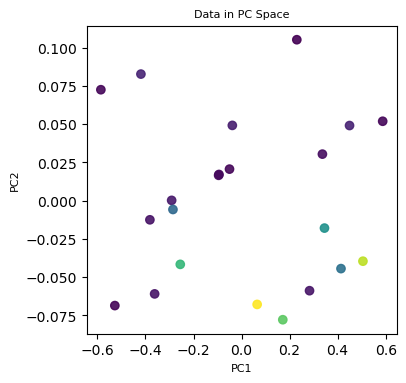

In [53]:
plt.figure(figsize=(4,4))
plt.scatter(PCs[:,0],PCs[:,1],alpha=0.9, c = age)
plt.xlabel('PC1', fontsize = 8)
plt.ylabel('PC2', fontsize = 8)
plt.title('Data in PC Space', fontsize = 8)

Text(0.5, 1.0, 'Data in PC Space')

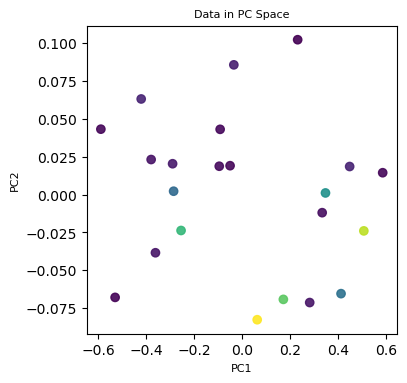

In [54]:
#plot rotated PC1 vs PC2 
plt.figure(figsize=(4,4))
plt.scatter(PCr[:,0],PCr[:,1],alpha=0.9, c= age)
plt.xlabel('PC1', fontsize = 8)
plt.ylabel('PC2', fontsize = 8)
plt.title('Data in PC Space', fontsize = 8)


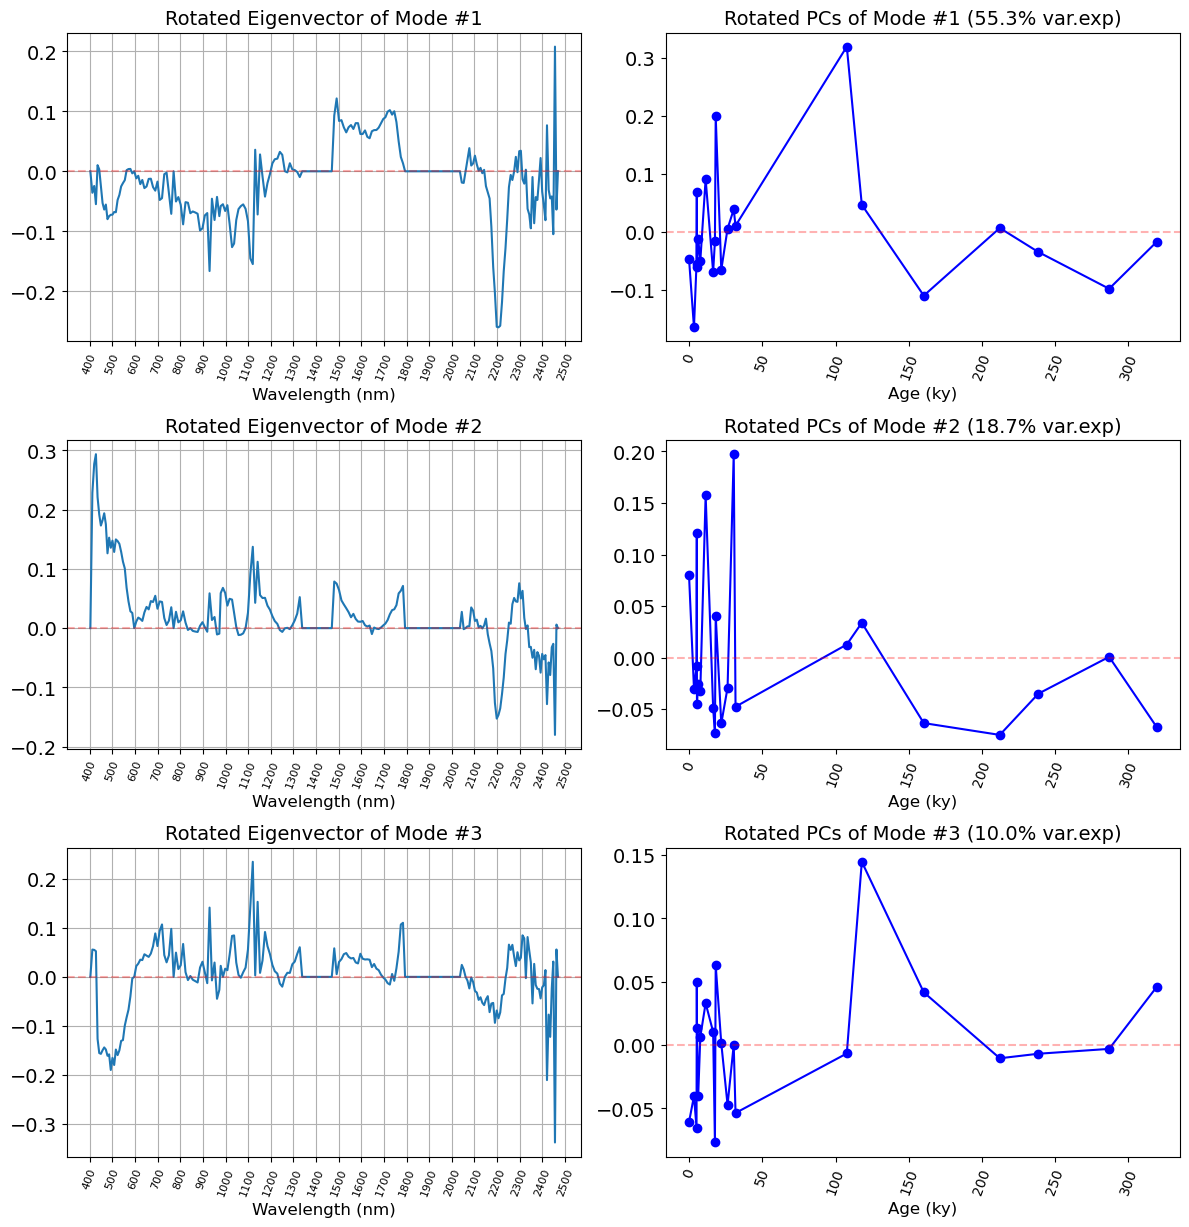

In [55]:
plt.figure(figsize=(12,4*n))

for kk in range(3):
    
    ax = plt.subplot(n,2,kk*2+1)
    plt.plot(nm_names, evects_rot[kk,:]) # extrat age as an array and do plt.plot(PCs[:,kk], age)
    plt.title('Rotated Eigenvector of Mode #' + str(kk+1), fontsize = 14)
    plt.xlabel('Wavelength (nm)', fontsize = 12)
    plt.xticks(fontsize = 10, rotation=70, size = 8)
    plt.xticks(np.arange(400, 2600, 100), fontsize = 10, rotation=70, size = 8)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    plt.grid()
    
    plt.subplot(n,2,(kk+1)*2)
    #plt.plot(age[1:],PCs[:,kk][1:], color = 'black')
    #plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
    #plt.plot(age_proxy, ice_proxy['dO18'], color = 'red', alpha =.8 ,label = 'Korner 2002 Global d18O (temp. proxy)')
    plt.scatter(age,PCr[:,kk], color = 'blue')
    plt.plot(age,PCr[:,kk], color = 'blue')
    #plt.colorbar(label = 'Age (ky)')
    plt.title('Rotated PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    plt.xlabel('Age (ky)', fontsize = 12)
    plt.xticks(fontsize = 14, rotation=70, size = 10)
    plt.yticks(fontsize = 14)  
    plt.tight_layout()
    plt.xlim()
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    
plt.show()

No handles with labels found to put in legend.


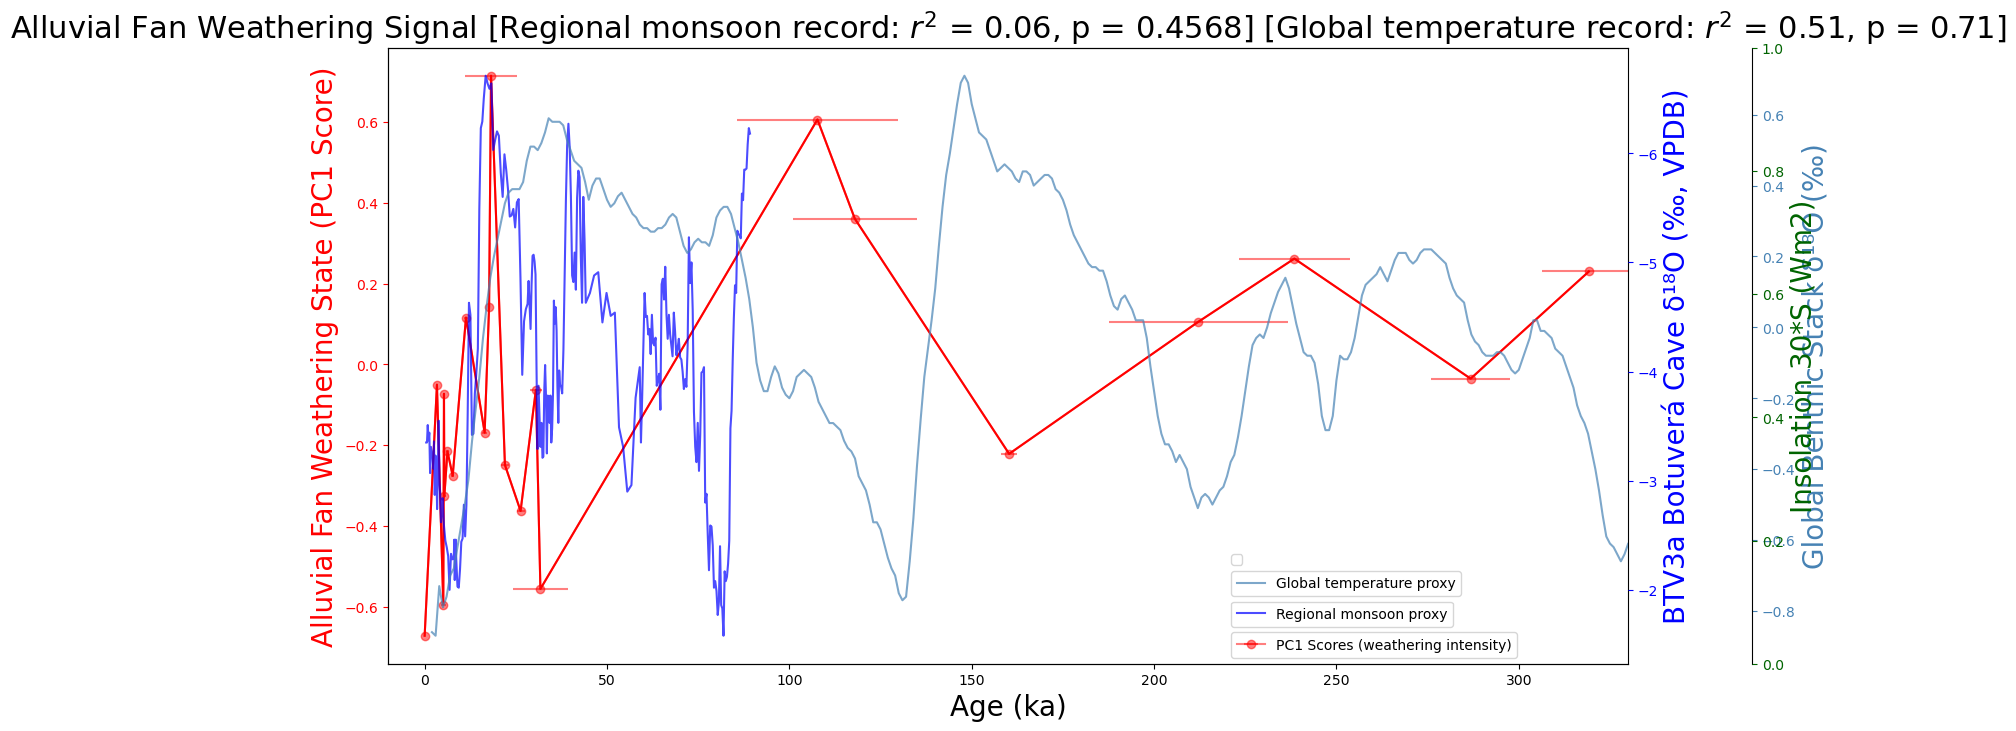

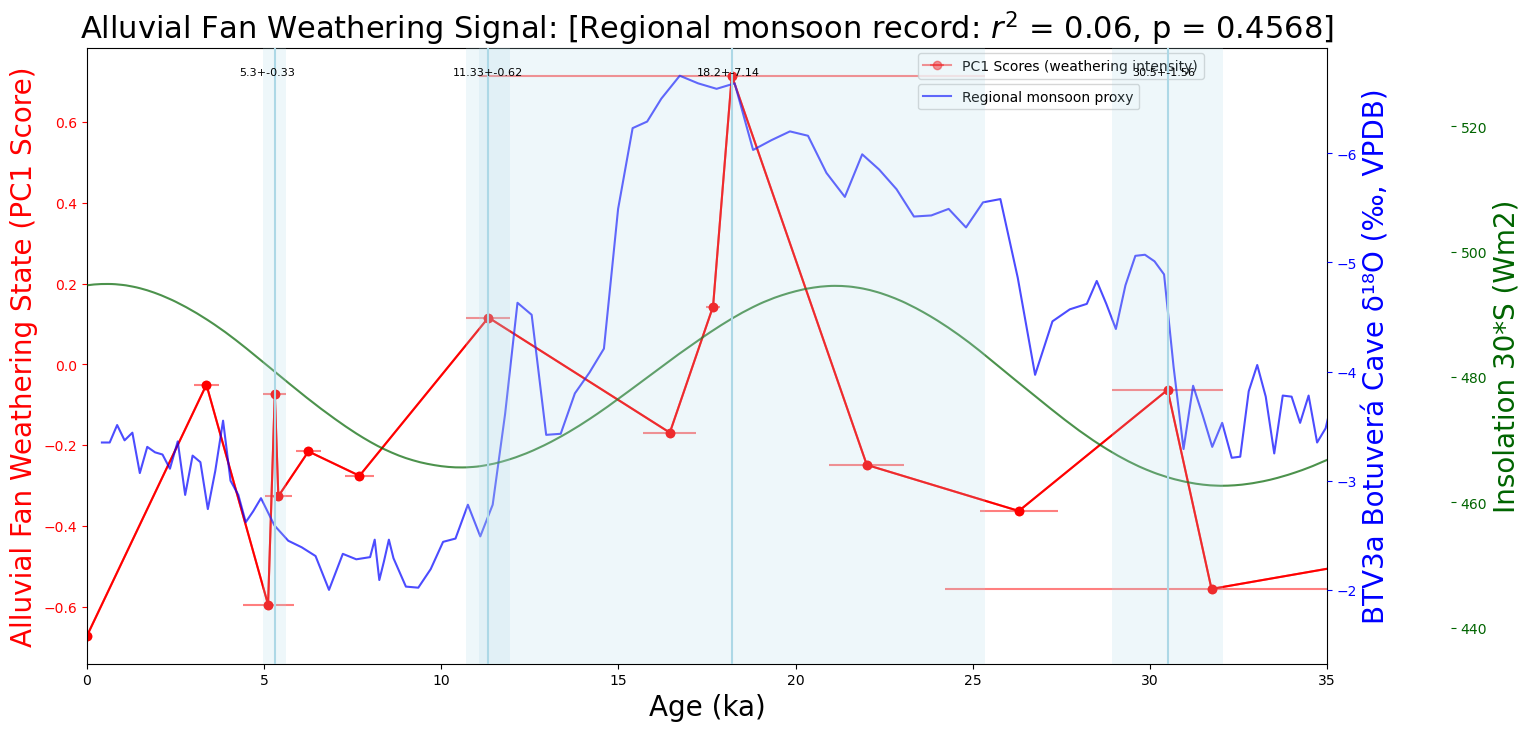

In [117]:
# It seems like normalizing between bands, but not obs, is best. Varimax rotation, and take the second PC (first is shadows). Then take residuals to account for age. Smaller events (HS1, YD) become prevelant. 
# Otherwise, a better general fit can be made if normalizing between all bands, and not rotating. Or using the differencing method. 
starting_idx = 0
PC = 0
x_values1=age[starting_idx:]

y_values1=PCs[:,PC][starting_idx:]
y_values1=PCr[:,PC][starting_idx:]
#y_values1=residuals[starting_idx:]
#y_values1 = diff_PC[starting_idx:]*-1
#y_values1 = pls_scores[:,PC][starting_idx:]
y_values1 = ratio[starting_idx:]


c1 = 'red'

x_values2=age_precip_proxy
y_values2=precip_proxy
c2 = 'blue'

x_values3= age_proxy
y_values3= ice_proxy*-1
c3 = 'steelblue'

x_values4= ins_age
y_values4= ins
c4 = 'darkgreen'

xmin = -10
xmax = 330

fig=plt.figure(figsize = (16,8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax3=fig.add_subplot(111, label="3", frame_on=True)
ax4=fig.add_subplot(111, label="4", frame_on=False)

ax3.patch.set_visible(False)


ax.plot(x_values1, y_values1, color=c1)
ax.set_xlim(left = xmin, right=xmax)
ax.errorbar(x_values1, y_values1, xerr=age_sd[starting_idx:], alpha = 0.5, c ='red', fmt='-o', label = 'PC1 Scores (weathering intensity)')
ax.set_xlabel('Age (ka)', color='black', size = 20)
ax.set_ylabel('Alluvial Fan Weathering State (PC1 Score)', color=c1, size = 20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors=c1)
#for i in range(starting_idx,np.where(age <= xmax)[0].max()+1): ax.text(x=x_values1[i-starting_idx], y=y_values1[i-starting_idx], s=(str(age[i]) + '+-' + str(age_sd[i])), transform=ax.transData) # add age labels to data points


ax2.plot(x_values2, y_values2, color=c2, alpha = 0.7, label = 'Regional monsoon proxy')
ax2.set_xlim(left = xmin, right=xmax)
ax2.set_xticks([])
ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax2.set_ylabel('BTV3a Botuverá Cave δ¹⁸O (‰, VPDB)', color=c2, size = 20)       
#ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax2.tick_params(axis='y', colors=c2)
ax2.invert_yaxis()

ax3.plot(x_values3, y_values3, color=c3, alpha = 0.7, label = 'Global temperature proxy')
ax3.set_xlim(left = xmin, right=xmax)
ax3.set_xticks([])
ax3.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax3.set_ylabel('Global Benthic Stack δ¹⁸O (‰)', color=c3, size =20)
#ax2.xaxis.set_label_position('top') 
ax3.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax3.tick_params(axis='y', colors=c3)
ax3.spines['right'].set_position(('axes', 1.1))

#ax4.plot(x_values4, y_values4, color=c4, alpha = 0.7, label = 'Insolation 30*S')
ax4.set_xlim(left = xmin, right=xmax)
ax4.set_xticks([])
ax4.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax4.set_ylabel('Insolation 30*S (Wm2)', color=c4, size =20)
#ax2.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax4.tick_params(axis='y', colors=c4)
ax4.spines['right'].set_position(('axes', 1.1))

ax.legend(loc = [.68,.01])
ax2.legend(loc = [.68,.06])
ax3.legend(loc = [.68,.11])
ax4.legend(loc = [.68,.16])


plt.title('Alluvial Fan Weathering Signal [Regional monsoon record: $r^2 $ = {}, p = {}] [Global temperature record: $r^2 $ = {}, p = {}]'.format(round(rho_precip**2,2), round(p_precip,4), round(rho_pre_lgm**2,2), round(rho_pre_lgm,2)), size = 22)


xmin = 0
xmax = 35

fig=plt.figure(figsize = (16,8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax4=fig.add_subplot(111, label="2", frame_on=False)


ax.plot(x_values1, y_values1, color=c1)
ax.set_xlim(left = xmin, right=xmax)
ax.scatter(x_values1, y_values1, color=c1)
ax.errorbar(x_values1, y_values1, xerr=age_sd[starting_idx:], alpha = 0.5, c ='red', fmt='-o', label = 'PC1 Scores (weathering intensity)')
ax.set_xlabel("Age (ka)", color='black', size = 20)
ax.set_ylabel("Alluvial Fan Weathering State (PC1 Score)", color=c1, size = 20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors=c1)
#for i in range(starting_idx,np.where(age <= xmax)[0].max()+1): ax.text(x=x_values1[i-starting_idx], y=y_values1[i-starting_idx], s=(str(age[i]) + '+-' + str(age_sd[i])), transform=ax.transData) # add age labels to data points

    
ax2.plot(x_values2, y_values2, color=c2, alpha = 0.7, label = 'Regional monsoon proxy')
ax2.set_xlim(left = xmin, right=xmax)
ax2.set_xticks([])
ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax2.set_ylabel('BTV3a Botuverá Cave δ¹⁸O (‰, VPDB)', color=c2, size = 20)       
#ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax2.tick_params(axis='y', colors=c2)
ax2.invert_yaxis()
ax.legend(loc = [.67,.95])
ax2.legend(loc = [.67,.9])

ax4.plot(x_values4, y_values4, color=c4, alpha = 0.7, label = 'Insolation 30*S')
ax4.set_xlim(left = xmin, right=xmax)
ax4.set_xticks([])
ax4.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
ax4.set_ylabel('Insolation 30*S (Wm2)', color=c4, size =20)
#ax2.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax4.tick_params(axis='y', colors=c4)
ax4.spines['right'].set_position(('axes', 1.1))

# peaks
ax5=fig.add_subplot(111, label="2", frame_on=False)
df = pd.DataFrame({'y':PCs[:,0],
                   'x':age})
peaks, _ = find_peaks(df['y'])
peak_l = age[peaks] - age_sd[peaks]
peak_r = age[peaks] + age_sd[peaks]


for peak_l, peak_r in zip(peak_l, peak_r):
    ax5.axvspan(peak_l, peak_r, facecolor='lightblue', alpha=.2) # plot left and right of peaks based on age sd
    
for peak in peaks:
    ax5.axvline(x= age[peak], color='lightblue', alpha= 1) # plot age of peak based on age mean
    
for peak in peaks[0:len(np.where(age[peaks] <= xmax)[0])]:
    ax5.text(x=age[peak] - 1, y=y_values1.max(), s=(str(age[peak]) + '+-' + str(age_sd[peak])), transform=ax.transData, size = 8) # add age labels to peaks
    
ax5.set_xlim(left = xmin, right=xmax)
ax5.set_xticks([])
ax5.set_yticks([])

plt.title('Alluvial Fan Weathering Signal: [Regional monsoon record: $r^2 $ = {}, p = {}]'.format(round(rho_precip**2,2), round(p_precip,4)), size = 22)

plt.show()

(0.0, 35.0)

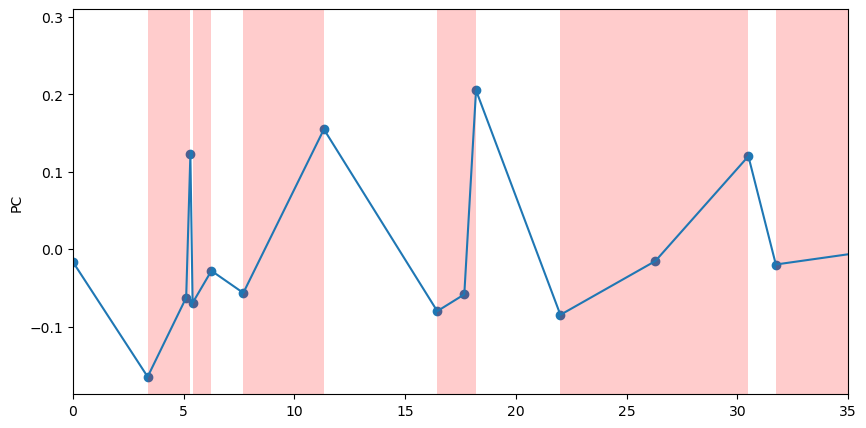

In [58]:
# Fin and plot peaks!
from scipy.signal import find_peaks       # v 1.5.2

df = pd.DataFrame({'y':PCs[:,0],
                   'x':age})

fig = plt.figure(figsize=(10, 5))
ax=fig.add_subplot(111, ylabel='PC')
ax.plot(df['x'],df['y'])
#ax.grid(axis='x', alpha=0.3)

peaks, _ = find_peaks(df['y'])
troughs, _ = find_peaks(-df['y'], width=.01, prominence=.01)
for peak, trough in zip(peaks, troughs):
    ax.axvspan(age[peak], age[trough], facecolor='red', alpha=.2)
    
plt.scatter(df['x'],df['y'])
plt.xlim(0,35)

In [1008]:
age[peaks]

array([  3.37,   5.3 ,  11.33,  18.2 ,  30.5 , 117.95, 238.47])

In [1012]:
peak_l = age[peaks] - age_sd[peaks]
peak_l

array([  3.01,   4.97,  10.71,  11.06,  28.94, 100.87, 223.26])

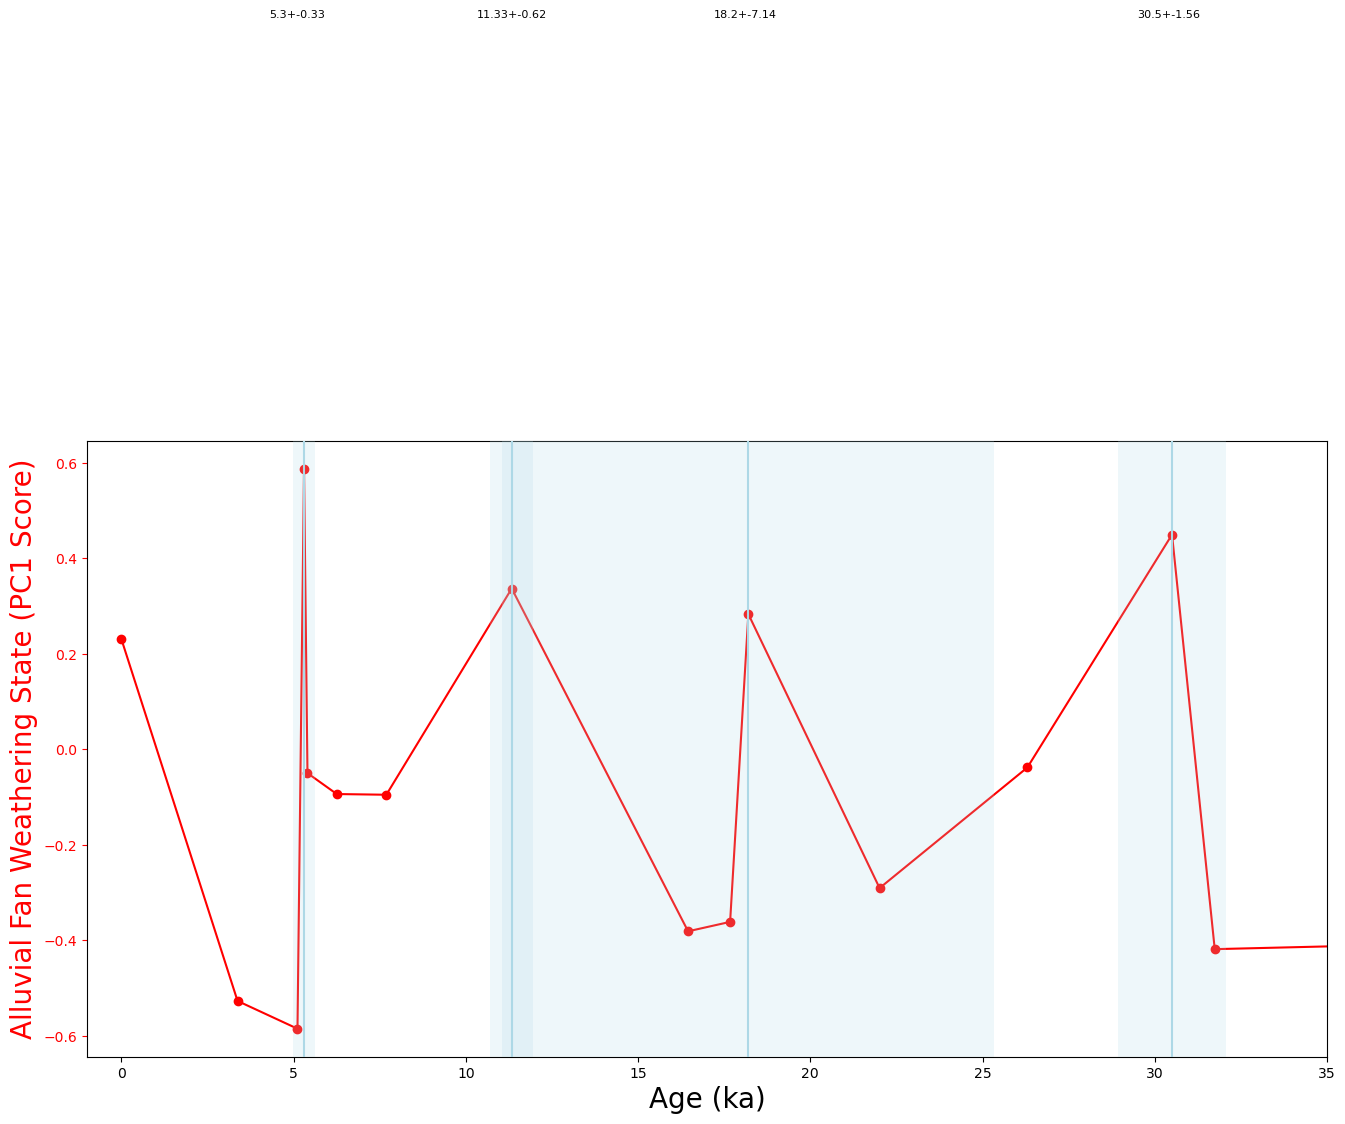

In [99]:
from scipy.signal import find_peaks       # v 1.5.2

xmin = -1
xmax= 35

df = pd.DataFrame({'y':PCs[:,0],
                   'x':age})
peaks, _ = find_peaks(df['y'])
peak_l = age[peaks] - age_sd[peaks]
peak_r = age[peaks] + age_sd[peaks]



fig=plt.figure(figsize = (16,8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)


ax.plot(df['x'],df['y'], color=c1)
ax.scatter(df['x'],df['y'], color=c1)
ax.set_xlim(left = xmin, right=xmax)
#ax.errorbar(x_values1, y_values1, xerr=age_sd[starting_idx:], alpha = 0.5, c ='red', fmt='-o', label = 'PC1 Scores (weathering intensity)')
ax.set_xlabel('Age (ka)', color='black', size = 20)
ax.set_ylabel('Alluvial Fan Weathering State (PC1 Score)', color=c1, size = 20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors=c1)
#for i in range(starting_idx,np.where(age <= xmax)[0].max()+1): ax.text(x=x_values1[i-starting_idx], y=y_values1[i-starting_idx], s=(str(age[i]) + '+-' + str(age_sd[i])), transform=ax.transData) # add age labels to data points


for peak_l, peak_r in zip(peak_l, peak_r):
        ax2.axvspan(peak_l, peak_r, facecolor='lightblue', alpha=.2) # plot left and right of peaks based on age sd
for peak in peaks:
    ax2.axvline(x= age[peak], color='lightblue', alpha= 1) # plot age of peak based on age mean
    
for peak in peaks[0:len(np.where(age[peaks] <= xmax)[0])]:
    ax2.text(x=age[peak] - 1, y=y_values1.max(), s=(str(age[peak]) + '+-' + str(age_sd[peak])), transform=ax.transData, size = 8) # add age labels to peaks
    
ax2.set_xlim(left = xmin, right=xmax)
ax2.set_xticks([])
ax2.set_yticks([])

#ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
#ax2.xaxis.set_label_position('top') 
#ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
#ax2.tick_params(axis='y', colors=c2)
ax2.invert_yaxis()

In [ ]:

for peak in peaks:
    ax2.axvline(x= age[peak], color='lightblue', alpha= 1)
ax2.set_xlim(left = xmin, right=xmax)
ax2.set_xticks([])
ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color=c2) 
#ax2.xaxis.set_label_position('top') 
#ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x', colors=c2)
ax2.tick_params(axis='y', colors=c2)
ax2.invert_yaxis()

5

(0.0, 35.0)

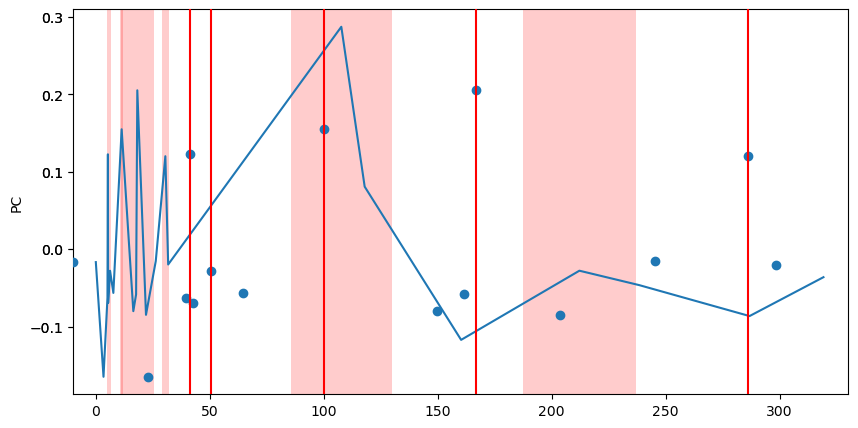

In [60]:
# Fin and plot peaks!
from scipy.signal import find_peaks       # v 1.5.2

xmin = -10
xmax= 330

df = pd.DataFrame({'y':PCs[:,0],
                   'x':age})

fig = plt.figure(figsize=(10, 5))
ax=fig.add_subplot(111, ylabel='PC')

ax.set_xlim(left = xmin, right=xmax)

ax2=fig.add_subplot(111, frame_on=False)
ax2.set_xlim(left = xmin, right=xmax)
ax2.set_xticks([])

ax.plot(df['x'],df['y'])

#ax.grid(axis='x', alpha=0.3)

peaks, _ = find_peaks(df['y'])
peak_l = age[peaks] - age_sd[peaks]
peak_r = age[peaks] + age_sd[peaks]


for peak_l, peak_r in zip(peak_l, peak_r):
        ax.axvspan(peak_l, peak_r, facecolor='red', alpha=.2)

    
for peak in peaks:
    plt.axvline(x= age[peak], color='red', alpha= 1)
    
plt.scatter(df['x'],df['y'])
plt.xlim(0,35)

In [1017]:
 ax.fill_between?

Signature:
ax.fill_between(
    x,
    y1,
    y2=0,
    where=None,
    interpolate=False,
    step=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Fill the area between two horizontal curves.

The curves are defined by the points (*x*, *y1*) and (*x*,
*y2*).  This creates one or multiple polygons describing the filled
area.

You may exclude some horizontal sections from filling using *where*.

By default, the edges connect the given points directly.  Use *step*
if the filling should be a step function, i.e. constant in between
*x*.

Parameters
----------
x : array (length N)
    The x coordinates of the nodes defining the curves.

y1 : array (length N) or scalar
    The y coordinates of the nodes defining the first curve.

y2 : array (length N) or scalar, default: 0
    The y coordinates of the nodes defining the second curve.

where : array of bool (length N), optional
    Define *where* to exclude some horizontal regions from being filled.
    The filled regions are defined 

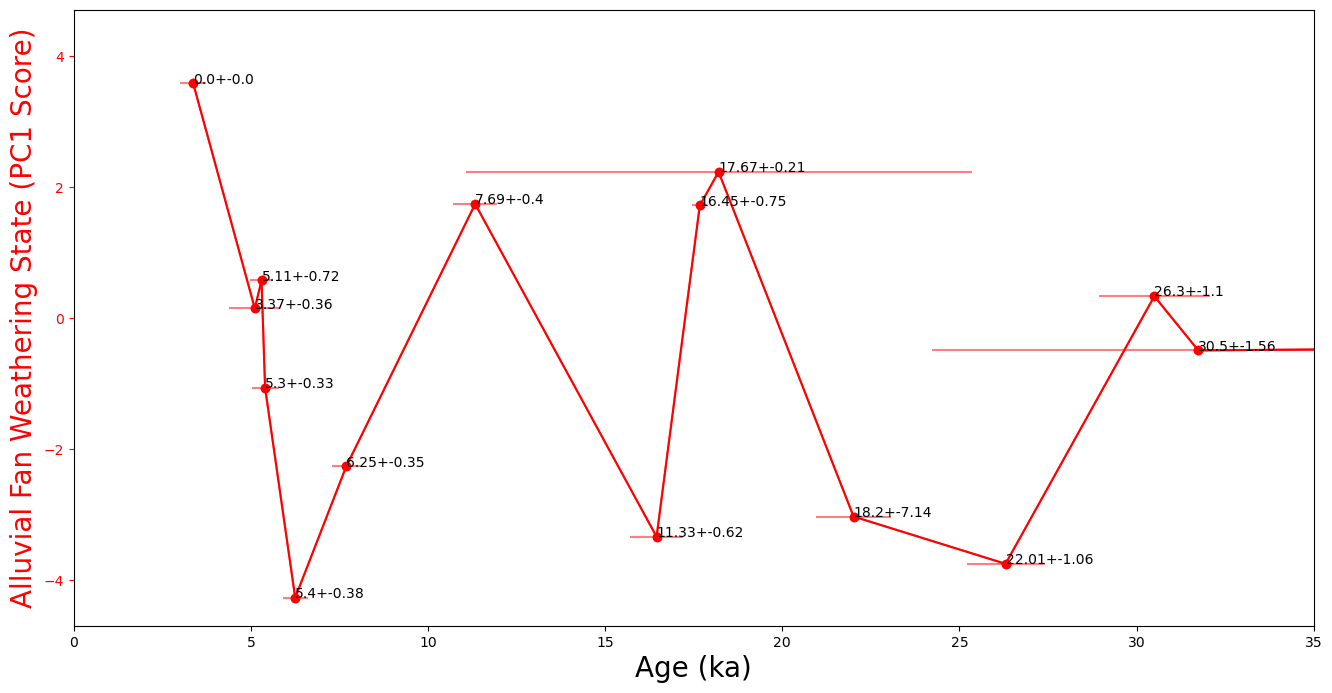

In [936]:
xmin = 0
xmax = 35

fig=plt.figure(figsize = (16,8))
ax=fig.add_subplot(111, label="1")



ax.plot(x_values1, y_values1, color=c1)
ax.set_xlim(left = xmin, right=xmax)
ax.scatter(x_values1, y_values1, color=c1)
ax.errorbar(x_values1, y_values1, xerr=age_sd[starting_idx:], alpha = 0.5, c ='red', fmt='-o', label = 'PC1 Scores (weathering intensity)')
ax.set_xlabel("Age (ka)", color='black', size = 20)
ax.set_ylabel("Alluvial Fan Weathering State (PC1 Score)", color=c1, size = 20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors=c1)
for i in range(np.where(x_values1 <= xmax)[0].max() + 1): 
    ax.text(x=x_values1[i], y=y_values1[i], s=(str(age[i]) + '+-' + str(age_sd[i])), transform=ax.transData)



In [900]:
range(13)

range(0, 13)

In [933]:

str(age[1])

'3.37'

In [822]:
for i in range(0,22):
    print(str(age[i]) + ' +- ' + str(age_sd[i]))

0.0 +- 0.0
3.37 +- 0.36
5.11 +- 0.72
5.3 +- 0.33
5.4 +- 0.38
6.25 +- 0.35
7.69 +- 0.4
11.33 +- 0.62
16.45 +- 0.75
17.67 +- 0.21
18.2 +- 7.14
22.01 +- 1.06
26.3 +- 1.1
30.5 +- 1.56
31.74 +- 7.53
107.7 +- 22.1
117.95 +- 17.08
160.26 +- 2.17
212.15 +- 24.62
238.47 +- 15.21
286.8 +- 10.84
319.22 +- 12.78


In [809]:
age_sd[1:]

array([ 0.36,  0.72,  0.33,  0.38,  0.35,  0.4 ,  0.62,  0.75,  0.21,
        7.14,  1.06,  1.1 ,  1.56,  7.53, 22.1 , 17.08,  2.17, 24.62,
       15.21, 10.84, 12.78])

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(nm_names, eigvecs[0,:], c = 'b', label = 'standard')
plt.plot(nm_names, evects_rot[0,:], color = 'red', label = 'rotated')
plt.legend()
plt.title('rotated pca: eigenvector')

plt.subplot(122)
plt.scatter(age,PCs[:,1], color = 'blue')
plt.scatter(age,PCr[:,1], color = 'red')
plt.title('rotated pcs: eigenvector')
plt.xlim()

In [ ]:
target_PC = data[5]/data[1]

plt.scatter(age, ratio)

### PLS

In [ ]:
from sklearn.cross_decomposition import PLSRegression

In [ ]:
data_plot.iloc[:,bad_band_idx] = 0

In [ ]:
n_modes = np.min(np.shape(data)) 
pls = PLSRegression(n_components = n_modes)
Cs = pls.fit(data,age)
pls_vecs = pls.x_weights_
pls_scores = pls.x_scores_

In [ ]:
#plot the first n modes and PCs
n = 10

plt.figure(figsize=(12,4*n))
for kk in range(n):
    
    ax = plt.subplot(n,2,kk*2+1)
    plt.plot(nm_names,pls_vecs[:,kk]) # extrat age as an array and do plt.plot(PCs[:,kk], age)
    plt.title('Eigenvector of Mode #' + str(kk+1), fontsize = 14)
    plt.xlabel('Wavelength (nm)', fontsize = 12)
    plt.xticks(fontsize = 10, rotation=70, size = 8)
    plt.xticks(np.arange(400, 2600, 100), fontsize = 10, rotation=70, size = 8)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    plt.grid()
    
    plt.subplot(n,2,(kk+1)*2)
    #plt.plot(age[1:],PCs[:,kk][1:], color = 'black')
    #plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
    #plt.plot(age_proxy, ice_proxy['dO18'], color = 'red', alpha =.8 ,label = 'Korner 2002 Global d18O (temp. proxy)')
    #plt.errorbar(age,PCs[:,kk], xerr=age_sd, fmt='o', c = 'darkblue', alpha = 0.8, zorder = 0)
    plt.scatter(age,pls_scores[:,kk], c = 'darkblue', zorder = 1)
    plt.plot(age,pls_scores[:,kk])

    #plt.colorbar(label = 'Age (ky)')
    #plt.title('PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    plt.xlabel('Age (ky)', fontsize = 12)
    plt.xticks(fontsize = 14, rotation=70, size = 10)
    plt.yticks(fontsize = 14)  
    plt.tight_layout()
    plt.xlim()
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)

plt.show()

# yonger fan variation may be due to water on the fans, which effects the signal. Drier fans
# color by location
# invesitgate the PC1, for its age. 


In [ ]:
from sys import stdout
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from scipy.signal import savgol_filter
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score



In [ ]:
X = np.array(data)
#X = savgol_filter(X, 11, polyorder = 2, deriv=1)
#X = savgol_filter(X, 13, polyorder = 2,deriv=2)

y = age
wl = np.array(nm_names)

X[:,bad_band_idx] = 0 # if bad bands chosen, set band bands as 0 for PCA` #!!change to 0 if NOT normalizign first!!!

# Define the PLS regression object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X, y)
 
# Plot spectra
plt.figure(figsize=(8,9))

with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X.T)
    plt.ylabel('First derivative absorbance spectra')

    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0]))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')

    plt.show()

In [ ]:
# Get the list of indices that sorts the PLS coefficients in ascending order 
# of the absolute value
sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
# Sort spectra according to ascending absolute value of PLS coefficients
Xc = X[:,sorted_ind]

def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
 
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
 
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
 
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
 
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [ ]:

def simple_pls_cv(X, y, n_comp):
 
    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_c = pls.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)    
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression 
 
    z = np.polyfit(y, y_cv, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y, y_cv, c='red', edgecolors='k')
        ax.plot(z[1]+z[0]*y, y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.ylabel('Predicted Age')
        plt.xlabel('Measured Age')
        
        plt.show()

In [ ]:
simple_pls_cv(X, y, 8)

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X, y, 15)
simple_pls_cv(opt_Xc, y, ncomp)

In [ ]:
# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wl.ravel(), wl[sorted_ind][:wav])
 
import matplotlib.collections as collections
 
with plt.style.context(('ggplot')):
    ax.plot(wl, np.array(data_plot.T))
    plt.ylabel('First derivative absorbance spectra')
    plt.xlabel('Wavelength (nm)')
 
collection = collections.BrokenBarHCollection.span_where(
    wl, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)
 
plt.show()